# Описание задачи

К нам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».
Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих бурёнок!
Поэтому он просит нас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Нам нужно создать две прогнозные модели для отбора бурёнок в поголовье:
* Первая будет прогнозировать возможный удой у коровы (целевой признак Удой);
* Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

С помощью модели нужно отобрать коров по двум критериям:
* Средний удой за год — не менее 6000 килограммов,
* Молоко должно быть вкусным.

# Описание данных
**ferma_main.csv** - содержит данные о стаде фермера на текущий момент: 

__Параметры корма коровы__
* **ЭКЕ** (Энергетическая кормовая единица) — измерение питательности корма коровы;
* **Сырой протеин** — содержание сырого протеина в корме, в граммах;
* **СПО** (Сахаро-протеиновое соотношение) — отношение сахара к протеину в корме коровы.
* **Где паслась корова**
* **Тип пастбища** — ландшафт лугов, на которых паслась корова.

__Особенности коровы__
* **id** — номер коровы;
* **Порода** — порода коровы;
* **Возраст** — бинарный признак (менее_2_лет, более_2_лет);
* **Имя Папы** — порода папы коровы.

__Характеристики молока__
* **Жирность** — содержание жиров в молоке, в процентах;
* **Белок** — содержание белков в молоке, в процентах;
* **Вкус молока** — оценка вкуса по личным критериям фермера;
* **Удой** — масса молока, которую корова даёт в год, в килограммах.

**ferma_dad.csv** - хранит имя папы каждой коровы в стаде фермера.

**cow_buy.csv** — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. Структура таблицы почти аналогична ferma_main.csv, кроме нескольких особенностей:

* **Белок** и **Жирность** молока указаны на момент покупки — когда «ЭкоФерма» давала им свой корм.
* **Параметры кормления ЭКЕ**, **Сырой протеин**, **СПО** отсутствуют. Недавно технологи заказчика пересмотрели параметры корма и планируют их внедрить после расширения стада. Именно новые параметры нужно использовать, когда вы будете применять предсказательные модели к бурёнкам «ЭкоФермы». По новой схеме фермер планирует увеличить средние значения ЭКЕ, Сырой протеин, СПО на 5%.
* **Удой** и **Вкус** молока неизвестны — именно их и предстоит предсказать!

# Настройка рабочего пространства

In [75]:
from IPython.display import display, HTML 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline


In [76]:
display(HTML("<style>.container { width:90% !important; }</style>")) # чтобы листик в джупитре был пошире - не работает
pd.set_option("display.max_columns", None) # чтобы сам df был пошире
pd.set_option('display.max_colwidth', None) # чтобы df колонки были пошире
pd.set_option('display.float_format', '{:.2f}'.format) # окрунгление чисел в df, чтобы числа не печатал экспоненциально
pd.options.display.expand_frame_repr = False # для принта чтобы колонки не переносил рабоатет тольок в vs code, in jupyter notebook получается каша
# plt.style.use('dark_background') # темная тема на графиках

# **Шаг 1. Загрузим и изучим данные**

In [77]:
try:
    ferma_main_df = pd.read_csv('C:/Users/dmi-a/OneDrive/Рабочий стол/DS учеба/datasets/ferma_main.csv', sep=';')
    ferma_dad_df = pd.read_csv('C:/Users/dmi-a/OneDrive/Рабочий стол/DS учеба/datasets/ferma_dad.csv', sep=';')
    cow_buy_df = pd.read_csv('C:/Users/dmi-a/OneDrive/Рабочий стол/DS учеба/datasets/cow_buy.csv', sep=';')
except:
    ferma_main_df = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_main.csv', sep=';')
    ferma_dad_df = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_dad.csv', sep=';')
    cow_buy_df = pd.read_csv('https://code.s3.yandex.net/datasets/cow_buy.csv', sep=';')

Изучим признаки и данные. Определим, соответствуют ли они описанию задачи и стандартам оформления данных. 

In [78]:
ferma_main_df.head(4)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет


In [79]:
ferma_dad_df.head(4)

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный


In [80]:
cow_buy_df.head(4)

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет


### 1.1. Первичный вывод о состоянии данных

1) Мы видим, что нарушен один из основных принципов хранения данных: **в каждом столбце должен храниться только один принзнак**, группа различных признаков в одном столбце недопустима. Нормализуем хранение данных: распределеим признаки по раздельным столбцам (создадим для этого функцию, которая решит нашу задачу трижды для трех датафреймов). - это мы уже ликвидировали, указав сепаратор при загрузке sep=';'.

2) мы видим, что в основном датафрейме ferma_main_df **есть испорченные строки (в частности третья строка)**, в которой значения перепутаны, закономерность сдвига не выявить. Эти строки просто удалим.

3) Смущает то, что в двух датафреймах **есть колонки с одинаковым названием "%"**. Вероятно, **целая часть в одной колонке, а дробная часть значения в другой колонке.** И надо после разделения объединить всех столбцов эти столбцы с целой и дробной частью.

4) Необходимо стандартизировать **единообразие названия колонок**.

# **Шаг 2. Предобработка данных**

## **2.1. Стандартизация названий столбцов и их сдержимого**

Обработаем название каждой колонки:

* уберем пробелы с боков и нижние подчеркивания;
* уберем пояснения в скобках (пояснения достаточно в описании проекта сверху);
* приведем написание к единообразию: пусть все названия признаков будут большими буквами и общепринятые сокращения кг и г в том числе. 
* оставим на русском языке. 
* в самих значениях исправим при отображении дробных чисел запятую на точку.

Напишем для этого функцию.

In [81]:
def make_normalize_column_names(df):
    """Приводит к единообразию названия колонок"""
    column_names = df.columns
    new_column_names = []
    for name in column_names:
        name = re.sub(r'\([^)]*\)|,', '', name) # удаляет содержимое в скобках и запятые
        name = name.strip()
        name = name.replace('_', ' ')
        name = name.upper() 
        
        # Нормализуем пробелы вокруг %
        name = re.sub(r'\s*%\s*', ' %', name)  # любые пробелы вокруг % → один пробел перед %
        name = re.sub(r'\s+', ' ', name)       # множественные пробелы → один пробел
        
        # Замены ПОСЛЕ upper()
        name = name.replace('ТЕКУЩАЯ ЖИРНОСТЬ %', 'ЖИРНОСТЬ %')
        name = name.replace('ТЕКУЩИЙ УРОВЕНЬ БЕЛОК %', 'БЕЛОК %')

        new_column_names.append(name)

    for col,val in df.items():
        # заодно исправим сами данные: запятые на точки
        if col in df.columns:
            df[col] = df[col].astype(str).str.replace(',', '.')
    
    df.columns = new_column_names
    return df

In [82]:
ferma_main_df = make_normalize_column_names(ferma_main_df)
ferma_main_df.head(3)

,ID,УДОЙ КГ,ЭКЕ,СЫРОЙ ПРОТЕИН Г,СПО,ПОРОДА,ТИП ПАСТБИЩА,ПОРОДА ПАПЫ БЫКА,ЖИРНОСТЬ %,БЕЛОК %,ВКУС МОЛОКА,ВОЗРАСТ
0,1,5863,14.2,1743,0.89,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.89,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет


In [83]:
ferma_dad_df = make_normalize_column_names(ferma_dad_df)
ferma_dad_df.head(3)

,ID,ИМЯ ПАПЫ
0,1,Буйный
1,2,Соловчик
2,3,Барин


In [84]:
cow_buy_df = make_normalize_column_names(cow_buy_df)
cow_buy_df.head(3)

,ПОРОДА,ТИП ПАСТБИЩА,ПОРОДА ПАПЫ БЫКА,ИМЯ ПАПЫ,ЖИРНОСТЬ %,БЕЛОК %,ВОЗРАСТ
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет


## **2.2. Удаление испорченных строк**

Пример испорченной строки, которую увидели сразу: 
* смещение и несооответствие количества значений количеству столбцов.

In [85]:
ferma_main_df.loc[[2]]

,ID,УДОЙ КГ,ЭКЕ,СЫРОЙ ПРОТЕИН Г,СПО,ПОРОДА,ТИП ПАСТБИЩА,ПОРОДА ПАПЫ БЫКА,ЖИРНОСТЬ %,БЕЛОК %,ВКУС МОЛОКА,ВОЗРАСТ
2,3,5810,14,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет


Поищем другие испорченные строки по типу третьей: возьмем за условие, что если в числовом столбце встречаются слова (или наоборот), значит вся строка испорченная и будем такую строку удалять.

1) сначала в автоматическом режиме определим тип столбца на основе подсчета индексов: каких индексов больше в столбце буквенных или цифровых - значит, соответсвующий тип столбца;
2) если список с числовыми индексами больше, то удалим лишние строки со строковыми индексами и наоборот

In [86]:
def find_bad_string(df, name=None):
    """Ищет испорченные строки в датафрейме. Если встречается нетиповое значение для данного столбца, то вся строка удаляется.
        1) сначала в автоматическом режиме определим тип столбца на основе подсчета индексов: каких индексов больше в столбце буквенных или цифровых;
        2) если список с числовыми индексами больше, то удалим строковые индексы и наоборот"""
    
    print('Определим нетиповые значения в столбце....\n')

    result = []

    for col in df:
        int_index_collector = []
        str_index_collector = []

        # так как все значения в DataFrame являются строками (даже числа хранятся как строки). isinstance(value, int) никогда не срабатывает.
        # поэтому будет проверять тип данных через try except

        for idx, value in df[col].items():
            # Проверяем, можно ли преобразовать в число
            try:
                int(value)
                int_index_collector.append(idx)
            except (ValueError, TypeError):
                str_index_collector.append(idx)

        if len(int_index_collector) > len(str_index_collector):
            print(f"Столбец {col:.<25} определен как числовой")

            if str_index_collector:
                df = df.drop(str_index_collector)
                print(f'- удалены искаженные строки с индексами {str_index_collector}\n')
                result.append(str_index_collector)

        elif len(int_index_collector) < len(str_index_collector):
            print(f"Столбец {col:.<25} определен как строковый")

            if int_index_collector:
                df = df.drop(int_index_collector)
                print(f'- удалены искаженные строки с индексами {int_index_collector}\n')
                result.append(int_index_collector)
                
        else:
            print(f"Столбец {col:.<25} не содержит нетиповых значений")

    if result:
        print(f'\nТаким образом, из датафрейма {name} удалены все испорченные строки с индексами {result} ')
    else:
        print(f'\nВ датафрейме {name} нет испорченных строк')

    return df

In [87]:
ferma_main_df = find_bad_string(ferma_main_df, 'ferma_main_df')

Определим нетиповые значения в столбце....

Столбец ID....................... определен как числовой
Столбец УДОЙ КГ.................. определен как числовой
Столбец ЭКЕ...................... определен как строковый
- удалены искаженные строки с индексами [2, 14, 63, 87, 161, 326, 332, 364, 385, 395, 396, 452, 466, 510, 513, 561, 588, 590]

Столбец СЫРОЙ ПРОТЕИН Г.......... определен как числовой
Столбец СПО...................... определен как строковый
Столбец ПОРОДА................... определен как строковый
Столбец ТИП ПАСТБИЩА............. определен как строковый
Столбец ПОРОДА ПАПЫ БЫКА......... определен как строковый
Столбец ЖИРНОСТЬ %............... определен как строковый
Столбец БЕЛОК %.................. определен как строковый
Столбец ВКУС МОЛОКА.............. определен как строковый
Столбец ВОЗРАСТ.................. определен как строковый

Таким образом, из датафрейма ferma_main_df удалены все испорченные строки с индексами [[2, 14, 63, 87, 161, 326, 332, 364, 385, 395, 39

In [88]:
cow_buy_df = find_bad_string(cow_buy_df, 'cow_buy_df')

Определим нетиповые значения в столбце....

Столбец ПОРОДА................... определен как строковый
Столбец ТИП ПАСТБИЩА............. определен как строковый
Столбец ПОРОДА ПАПЫ БЫКА......... определен как строковый
Столбец ИМЯ ПАПЫ................. определен как строковый
Столбец ЖИРНОСТЬ %............... определен как строковый
Столбец БЕЛОК %.................. определен как строковый
Столбец ВОЗРАСТ.................. определен как строковый

В датафрейме cow_buy_df нет испорченных строк


In [89]:
ferma_dad_df = find_bad_string(ferma_dad_df, 'ferma_dad_df')

Определим нетиповые значения в столбце....

Столбец ID....................... определен как числовой
Столбец ИМЯ ПАПЫ................. определен как строковый

В датафрейме ferma_dad_df нет испорченных строк


## **2.3. Приведение типов данных**

Узнаем для каждой таблицы, корректны ли типы данных у каждого признака, а затем исправим типы данных. Написать функцию для этого не нахожу возможным, так как смотреть типы надо всегда вручную.

Строковый тип object предлагаю заменить на category, его приемущество в том, что не надо хранить 1000 одинаковых значений при больших объемах, а только уникальные значения из списка, что экономит память, а также является более семантичным при работе с категориальными признаками.

In [90]:
ferma_main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 616 entries, 0 to 633
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                616 non-null    object
 1   УДОЙ КГ           616 non-null    object
 2   ЭКЕ               616 non-null    object
 3   СЫРОЙ ПРОТЕИН Г   616 non-null    object
 4   СПО               616 non-null    object
 5   ПОРОДА            616 non-null    object
 6   ТИП ПАСТБИЩА      616 non-null    object
 7   ПОРОДА ПАПЫ БЫКА  616 non-null    object
 8   ЖИРНОСТЬ %        616 non-null    object
 9   БЕЛОК %           616 non-null    object
 10  ВКУС МОЛОКА       616 non-null    object
 11  ВОЗРАСТ           616 non-null    object
dtypes: object(12)
memory usage: 62.6+ KB


In [91]:
dtype_dict = {
    'ID': 'int64',
    'ЭКЕ': 'float64', 
    'СПО': 'float64',
    'ПОРОДА': 'category',
    'ТИП ПАСТБИЩА': 'category',
    'ПОРОДА ПАПЫ БЫКА': 'category', 
    'ВКУС МОЛОКА': 'category',
    'ВОЗРАСТ': 'category',
    'УДОЙ КГ': 'float64',
    'СЫРОЙ ПРОТЕИН Г': 'float64',
    'ЖИРНОСТЬ %': 'float64',
    'БЕЛОК %': 'float64'
}

# Применяем типы
ferma_main_df = ferma_main_df.astype(dtype_dict)
ferma_main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 616 entries, 0 to 633
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   ID                616 non-null    int64   
 1   УДОЙ КГ           616 non-null    float64 
 2   ЭКЕ               616 non-null    float64 
 3   СЫРОЙ ПРОТЕИН Г   616 non-null    float64 
 4   СПО               616 non-null    float64 
 5   ПОРОДА            616 non-null    category
 6   ТИП ПАСТБИЩА      616 non-null    category
 7   ПОРОДА ПАПЫ БЫКА  616 non-null    category
 8   ЖИРНОСТЬ %        616 non-null    float64 
 9   БЕЛОК %           616 non-null    float64 
 10  ВКУС МОЛОКА       616 non-null    category
 11  ВОЗРАСТ           616 non-null    category
dtypes: category(5), float64(6), int64(1)
memory usage: 42.1 KB


Типы заменились успешно.

In [92]:
ferma_dad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        629 non-null    object
 1   ИМЯ ПАПЫ  629 non-null    object
dtypes: object(2)
memory usage: 10.0+ KB


In [93]:
dtype_dict = {
    'ID': 'int64',
    'ИМЯ ПАПЫ': 'category'
}

# Применяем типы
ferma_dad_df = ferma_dad_df.astype(dtype_dict)
ferma_dad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ID        629 non-null    int64   
 1   ИМЯ ПАПЫ  629 non-null    category
dtypes: category(1), int64(1)
memory usage: 5.9 KB


Типы заменились успешно.

In [94]:
cow_buy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ПОРОДА            20 non-null     object
 1   ТИП ПАСТБИЩА      20 non-null     object
 2   ПОРОДА ПАПЫ БЫКА  20 non-null     object
 3   ИМЯ ПАПЫ          20 non-null     object
 4   ЖИРНОСТЬ %        20 non-null     object
 5   БЕЛОК %           20 non-null     object
 6   ВОЗРАСТ           20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


In [95]:
dtype_dict = {
    'ПОРОДА': 'category',
    'ТИП ПАСТБИЩА': 'category', 
    'ПОРОДА ПАПЫ БЫКА': 'category',
    'ИМЯ ПАПЫ': 'category',
    'ВОЗРАСТ': 'category',
    'ЖИРНОСТЬ %': 'float64', 
    'БЕЛОК %': 'float64',
}

# Применяем типы
cow_buy_df = cow_buy_df.astype(dtype_dict)
cow_buy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   ПОРОДА            20 non-null     category
 1   ТИП ПАСТБИЩА      20 non-null     category
 2   ПОРОДА ПАПЫ БЫКА  20 non-null     category
 3   ИМЯ ПАПЫ          20 non-null     category
 4   ЖИРНОСТЬ %        20 non-null     float64 
 5   БЕЛОК %           20 non-null     float64 
 6   ВОЗРАСТ           20 non-null     category
dtypes: category(5), float64(2)
memory usage: 1.2 KB


Типы заменились успешно.

## **2.4. Проверка на пропуски**

Создадим отдельную функцию для проверки на пропуски и при необходимости заменим значения.

In [96]:
def check_null(df, fillna=False, dropna=False):
    """Проверяет на пропуски: при необходимости удаляет их или заменяет на стандартные значения. Параметр fillna=True: числовые значения заменяет медианой, категориальные - модой. парметр dropna=True: удаляет строки с пропусками. По умолчанию параметры стоят False."""
    missing_stats = pd.DataFrame({'Кол-во пропусков': df.isnull().sum(),
                                  'Объем пропусков': (100 * df.isnull().mean()).round(2).astype(str) + ' %'})
    missing_stats = missing_stats[missing_stats['Кол-во пропусков'] > 0]
    
    if not missing_stats.empty:
        display(missing_stats.style.background_gradient(cmap='coolwarm'))
    else:
        print("Нет пропусков в таблице")

    if fillna:
        for col in df.columns:
            if df[col].dtype in ['object', 'category']:
                df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown')
            else:
                df[col] = df[col].fillna(df[col].median())
        print("Числовые значения заменены медианой, категориальные модой")
        print(f"NaN значений после обработки: {df.isnull().sum().sum()}")
    
    if dropna:
        df = df.dropna()
        print("Строки с NaN удалены")
        print(f"NaN значений после обработки: {df.isnull().sum().sum()}")
    
    return df  # Добавили return

Проверим данные на наличие пропусков.

In [97]:
ferma_main_df = check_null(ferma_main_df)        


Нет пропусков в таблице


In [98]:
ferma_dad_df = check_null(ferma_dad_df)

Нет пропусков в таблице


In [99]:
cow_buy_df = check_null(cow_buy_df)

Нет пропусков в таблице


## **2.5. Дубликаты: проверка и обработка**

Для начала вспомним и зафиксирцуем размер таблицы.

In [100]:
print(f'- Размер таблицы ferma_main_df: {len(ferma_main_df)} наблюдений')
print(f'- Размер таблицы ferma_dad_df: {len(ferma_dad_df)} наблюдений')
print(f'- Размер таблицы cow_buy_df: {len(cow_buy_df)} наблюдения')

- Размер таблицы ferma_main_df: 616 наблюдений
- Размер таблицы ferma_dad_df: 629 наблюдений
- Размер таблицы cow_buy_df: 20 наблюдения


### **2.5.1. Проверка на явные дубликаты**

Проверим, есть ли в данных явные дубликаты. Опишем причины, которые могли повлиять на появление дублей.

In [101]:
print(f'- В таблице ferma_main_df {ferma_main_df.duplicated().sum()} явных дублей')
print(f'- В таблице ferma_dad_df {ferma_dad_df.duplicated().sum()} явных дублей')
print(f'- В таблице cow_buy_df {cow_buy_df.duplicated().sum()} явных дублей')

- В таблице ferma_main_df 5 явных дублей
- В таблице ferma_dad_df 0 явных дублей
- В таблице cow_buy_df 4 явных дублей


In [102]:
ferma_main_df[ferma_main_df.duplicated()]

,ID,УДОЙ КГ,ЭКЕ,СЫРОЙ ПРОТЕИН Г,СПО,ПОРОДА,ТИП ПАСТБИЩА,ПОРОДА ПАПЫ БЫКА,ЖИРНОСТЬ %,БЕЛОК %,ВКУС МОЛОКА,ВОЗРАСТ
629,627,5970.00,14.40,1837.00,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.08,не вкусно,более_2_лет
630,627,5970.00,14.40,1837.00,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.08,не вкусно,более_2_лет
631,627,5970.00,14.40,1837.00,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.08,не вкусно,более_2_лет
632,627,5970.00,14.40,1837.00,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.08,не вкусно,более_2_лет
633,627,5970.00,14.40,1837.00,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.08,не вкусно,более_2_лет


Почему образовались дубликаты - неизвестно. Удалим 5 явных дубликатов из таблицы ferma_main_df. Отсутвие дубликатов также важно и для буущего объеинения таблиц.

In [103]:
ferma_main_df = ferma_main_df.drop_duplicates().reset_index(drop=True)
print(f"Проверка количества дубликатов после удаления: {ferma_main_df.duplicated().sum()}")

Проверка количества дубликатов после удаления: 0


In [104]:
cow_buy_df[cow_buy_df.duplicated(keep=False)]

,ПОРОДА,ТИП ПАСТБИЩА,ПОРОДА ПАПЫ БЫКА,ИМЯ ПАПЫ,ЖИРНОСТЬ %,БЕЛОК %,ВОЗРАСТ
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.07,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.07,более_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.07,более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.07,более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.07,более_2_лет


Почему образовались дубликаты - неизвестно. Удалим 4 явных дубликата из таблицы cow_buy_df. Отсутвие дубликатов также важно и для буущего объеинения таблиц.

In [105]:
cow_buy_df = cow_buy_df.drop_duplicates().reset_index(drop=True)
print(f"Проверка количества дубликатов после удаления: {cow_buy_df.duplicated().sum()}")

Проверка количества дубликатов после удаления: 0


### **2.5.2. Проверка на неявные дубликаты**

Проверим на неявные дубликаты.

In [106]:
df_dict = {'ferma_main_df': ferma_main_df, 
           'ferma_dad_df': ferma_dad_df, 
           'cow_buy_df': cow_buy_df}

for name, df in df_dict.items():
    print(f'\n\ndf {name}:') 
    for col in df:
        print(f'Столбец: {col}')
        print(f'Уникальных значений: {df[col].nunique()}\n {sorted(df[col].unique())}')
        print('='*30)



df ferma_main_df:
Столбец: ID
Уникальных значений: 611
 [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214,

Мы заметили неявные дубликаты в ferma_main_df:
* Столбец: ТИП ПАСТБИЩА неявные дубликаты: ['Равнинное', 'Равнинные'] - оставим равнинное
* Столбец: ПОРОДА ПАПЫ БЫКА неявные дубликаты: ['Айдиал', 'Айдиалл'] - оставим Айдиал

In [107]:
ferma_main_df['ТИП ПАСТБИЩА'] = ferma_main_df['ТИП ПАСТБИЩА'].replace('Равнинные', 'Равнинное')
ferma_main_df['ПОРОДА ПАПЫ БЫКА'] = ferma_main_df['ПОРОДА ПАПЫ БЫКА'].replace('Айдиалл', 'Айдиал')

print('Проверим остаток уникальных значений после замены:\n')
for col in ['ТИП ПАСТБИЩА', 'ПОРОДА ПАПЫ БЫКА']:
    print(f"{col}: {ferma_main_df[col].unique()}\n")

Проверим остаток уникальных значений после замены:

ТИП ПАСТБИЩА: ['Равнинное', 'Холмистое']
Categories (2, object): ['Равнинное', 'Холмистое']

ПОРОДА ПАПЫ БЫКА: ['Айдиал', 'Соверин']
Categories (2, object): ['Айдиал', 'Соверин']



C:\Users\dmi-a\AppData\Local\Temp\ipykernel_19528\839085137.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  ferma_main_df['ТИП ПАСТБИЩА'] = ferma_main_df['ТИП ПАСТБИЩА'].replace('Равнинные', 'Равнинное')
C:\Users\dmi-a\AppData\Local\Temp\ipykernel_19528\839085137.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  ferma_main_df['ПОРОДА ПАПЫ БЫКА'] = ferma_main_df['ПОРОДА ПАПЫ БЫКА'].replace('Айдиалл', 'Айдиал')


<div style="background-color: #d4edda; color: #155724; padding: 15px;a border-radius: 4px; border: 1px solid #c3e6cb;">

<b>Комментарий ревьюера v1:</b>
    
Хорошее решение для приведения данных к единому формату.


Корректировка неявных дубликатов проведена успешно.

## **2.6. Убираем выбросы**

Перед тем как смотреть статистический анализ данных и визуализировать взаимосвязь на графиках, необходимо убрать выбросы.

На всех графиках наблюдается какой-то один выброс по удою, которые превышает стандартные значения более чем в 4 раза. 




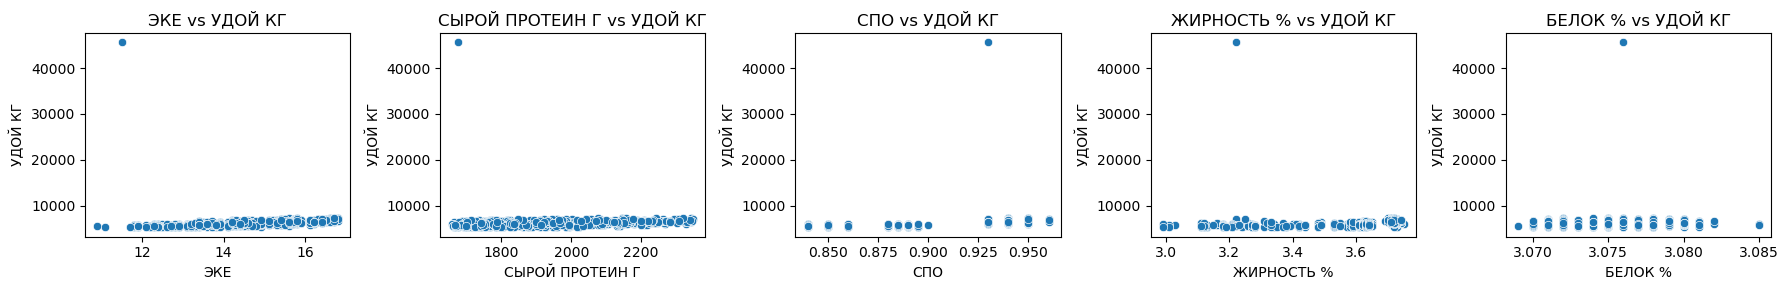

In [108]:
numeric_features = ['ЭКЕ', 'СЫРОЙ ПРОТЕИН Г', 'СПО', 'ЖИРНОСТЬ %', 'БЕЛОК %']

def show_outlier(df, numeric_features_list, target):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(18, 3))
    axes = axes.flatten()

    for i, col in enumerate(numeric_features_list):
        sns.scatterplot(data=df, x=col, y=target, ax=axes[i])
        axes[i].set_title(f'{col} vs {target}')

    plt.tight_layout()
    plt.show()

show_outlier(ferma_main_df, numeric_features, target='УДОЙ КГ')

Перед тем как строить графики предлагаю убрать сначала выбросы.

In [109]:
category_features = ['ПОРОДА', 'ТИП ПАСТБИЩА', 'ПОРОДА ПАПЫ БЫКА', 'ВКУС МОЛОКА', 'ВОЗРАСТ']

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

# Убираем выбросы по всем числовым признакам
for col in numeric_features:
    ferma_main_df = remove_outliers_iqr(ferma_main_df, col)

# Проверяем, что категориальные переменные остались
print("Числовые столбцы после удаления выбросов:", ferma_main_df.columns.tolist())
print("Категориальные переменные на месте:", [col for col in category_features if col in ferma_main_df.columns])
print('Выбросы убрали')

Числовые столбцы после удаления выбросов: ['ID', 'УДОЙ КГ', 'ЭКЕ', 'СЫРОЙ ПРОТЕИН Г', 'СПО', 'ПОРОДА', 'ТИП ПАСТБИЩА', 'ПОРОДА ПАПЫ БЫКА', 'ЖИРНОСТЬ %', 'БЕЛОК %', 'ВКУС МОЛОКА', 'ВОЗРАСТ']
Категориальные переменные на месте: ['ПОРОДА', 'ТИП ПАСТБИЩА', 'ПОРОДА ПАПЫ БЫКА', 'ВКУС МОЛОКА', 'ВОЗРАСТ']
Выбросы убрали


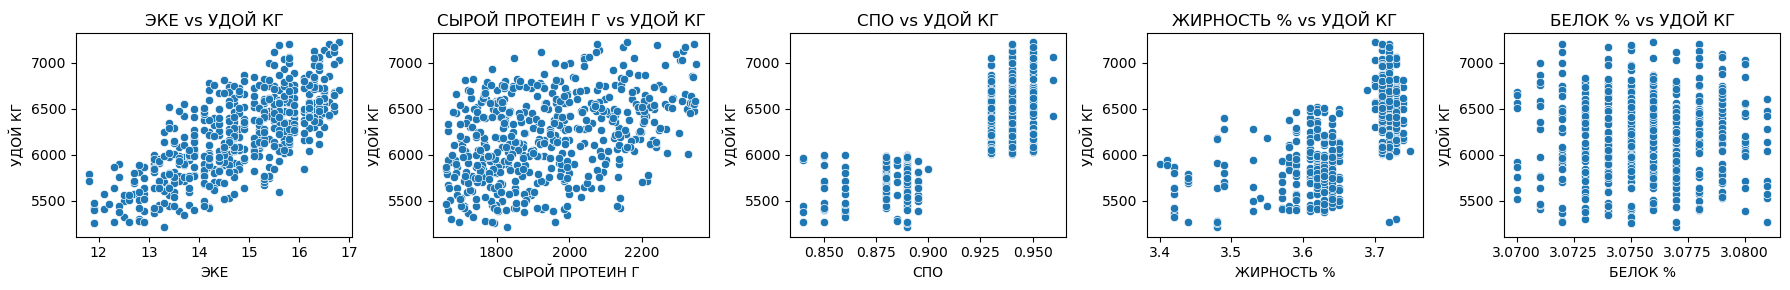

In [110]:
show_outlier(ferma_main_df, numeric_features, target='УДОЙ КГ')

<div style="background-color: #d4edda; color: #155724; padding: 15px; border-radius: 4px; border: 1px solid #c3e6cb;">

<b>Комментарий ревьюера v1:</b>

Все верно! Очень качественный анализ данных и выбросов.
    
Повторный анализ после удаления выброса - лучшая практика.


## **2.7. Промежуточный вывод предобработки данных**

1) Исправлены названия колонок:
* Убраны пробелы с боков и подчеркивания;
* Приведены названия к единому регистру;
* Переименованы некоторые столбцы;
* Убраны пояснения в скобках;
2) Склеены некоторые столбцы с целой и дробной частью, так как они д.б. единым целым (округлить эти значения не удалось до десятых);
3) Заменены типы данных;
4) Удалено 18 испорченных строк со смещением и путаницей данных;
5) Для большинства задач написаны функции, которые мы неоднократно применили к различным датафреймам;
6) Удалили неявные дубликаты;
7) Убрали выбросы.
8) заменили запятую на точку в дробных числах

<div style="background-color: #d4edda; color: #155724; padding: 15px; border-radius: 4px; border: 1px solid #c3e6cb;">

<b>Комментарий ревьюера v1:</b>
    
Верная предобработка данных 👏

Здорово, что оставляешь промежуточные выводы.

# **Шаг 3. Исследовательский анализ данных**

Проведем статистический анализ всех числовых признаков. 
* Статистический анализ проводится только для числовых признаков (отображаются только числовые признаки)

In [111]:
ferma_main_df.describe()

,ID,УДОЙ КГ,ЭКЕ,СЫРОЙ ПРОТЕИН Г,СПО,ЖИРНОСТЬ %,БЕЛОК %
count,522.00,522.00,522.00,522.00,522.00,522.00,522.00
mean,311.81,6210.77,14.79,1944.52,0.92,3.66,3.08
std,180.89,446.63,1.19,182.01,0.03,0.08,0.00
min,1.00,5207.00,11.80,1660.00,0.84,3.40,3.07
25%,156.25,5882.50,13.90,1795.00,0.89,3.62,3.07
50%,307.50,6235.00,14.85,1919.00,0.93,3.71,3.08
75%,468.75,6556.00,15.70,2087.00,0.94,3.72,3.08
max,629.00,7222.00,16.80,2349.00,0.96,3.75,3.08


У коров на ферме, которые во владении средняя жирность молока 3.7. А мы позже узнаем на графиках, что чем жирнее молоко у коровы, тем она способна давать больше молока.

In [112]:
cow_buy_df.describe()

,ЖИРНОСТЬ %,БЕЛОК %
count,16.00,16.00
mean,3.57,3.07
std,0.14,0.01
min,3.34,3.05
25%,3.42,3.06
50%,3.58,3.07
75%,3.69,3.08
max,3.77,3.08


Что мы видим, у коров, рассматриваемых к покупке средняя жирность молока меньше на 0.1. а значит, вероятно, они дают меньше молока. 

Построим графики, которые описывают все признаки. Помните, что количественным и категориальным данным подходят разные графики.

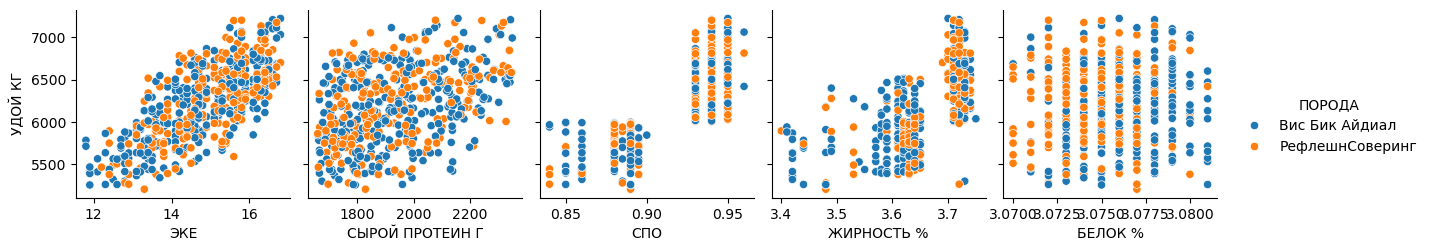

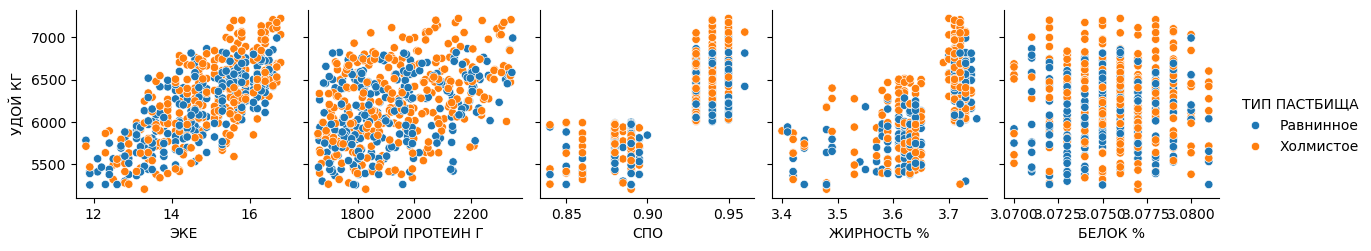

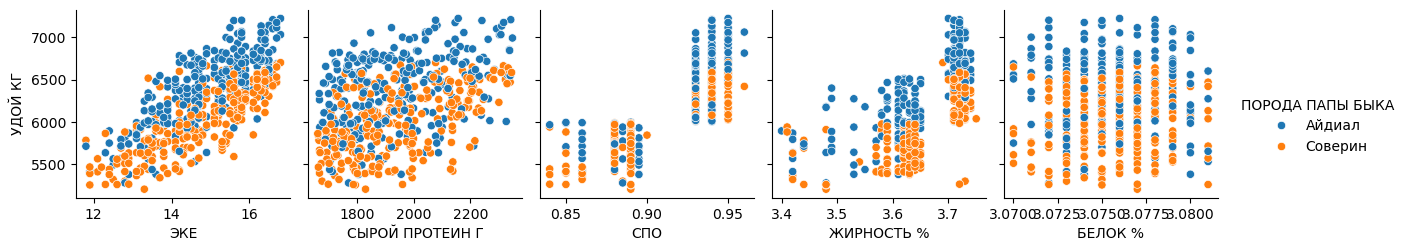

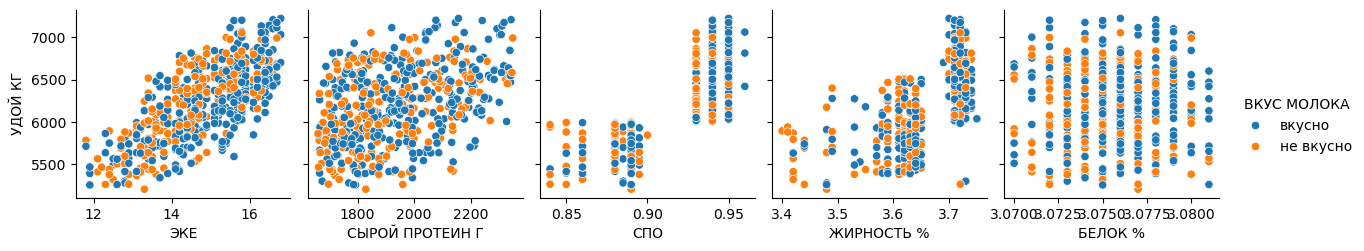

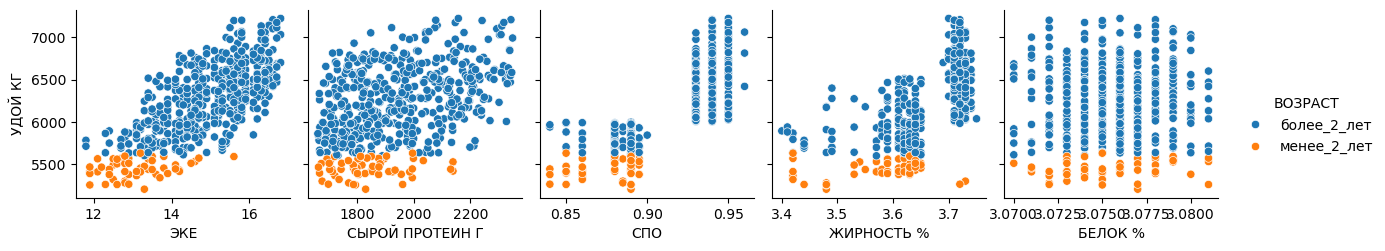

In [113]:
numeric_features = ['ЭКЕ', 'СЫРОЙ ПРОТЕИН Г', 'СПО', 'ЖИРНОСТЬ %', 'БЕЛОК %']
category_features = ['ПОРОДА', 'ТИП ПАСТБИЩА', 'ПОРОДА ПАПЫ БЫКА', 'ВКУС МОЛОКА', 'ВОЗРАСТ']
for category in category_features:
    sns.pairplot(ferma_main_df, x_vars=numeric_features, y_vars='УДОЙ КГ', hue=category)
plt.show()

* ЭКЕ (энергетическая кормовая единица - измерение питательности корма) не влияет на удой: при показателях от 1 до 9 есть небольшое повышение повышение с 3 до 5, а показатель 9 равен показателям 1 и 2. 
* Здесь мы видит, что примерно 80% коров дают удой при возрасте старше двух лет.
* Протеина содержится в молоке у коров старше двух лет.
* Чем выше удой, темм больше жирность у молока;
* Содержание белка не влияет на вкус, и коровы в независимости от  способности давать удой дают молоко одного вкуса.
* Больше протеина в молоке от коров, которе способны давать больший удой.
* коровы породы Айдиал дают немного больше удоя, чем Северины.
* Сахарно-протеиновое соотношение у Айдиалов выше.

<div style="background-color: #d4edda; color: #155724; padding: 15px; border-radius: 4px; border: 1px solid #c3e6cb;">

<b>Комментарий ревьюера v1:</b>

Верная тепловая карта и диаграммы рассеяния. Очень информативный шаг который позволяет увидеть более сложные зависимости.

# **Шаг 4. Корреляционный анализ**

Изучим взаимосвязь между целевым и входными признаками.

In [114]:
# Корреляция для числовых признаков
numeric_corr = ferma_main_df[numeric_features + ['УДОЙ КГ']].corr()['УДОЙ КГ'].drop('УДОЙ КГ')
print("Корреляция числовых признаков с УДОЙ КГ:")
print(numeric_corr.sort_values(key=abs, ascending=False))

# 1) + ['УДОЙ КГ'] - добавляем целевую переменную к числовым признакам для расчета корреляции
# .corr() - вычисляем корреляционную матрицу всех признаков
# 2) ['УДОЙ КГ'] - извлекаем только столбец с корреляциями относительно 'УДОЙ КГ'
# 3) .drop('УДОЙ КГ') - удаляем корреляцию 'УДОЙ КГ' с самим собой (всегда = 1.0)
# Результат: получаем корреляции всех числовых признаков с целевой переменной, исключая саму целевую переменную.

Корреляция числовых признаков с УДОЙ КГ:
СПО                0.80
ЭКЕ                0.74
ЖИРНОСТЬ %         0.65
СЫРОЙ ПРОТЕИН Г    0.39
БЕЛОК %           -0.00
Name: УДОЙ КГ, dtype: float64


* Наиболее сильная корреляция наблюдается удоя с СПО: чем выше сахаро-протеиновое сооотношение, тем выше удой; 
* а также второе значение по степени важности имеет ЭКЕ и жирность признак - как косвенный признак репродуктивного здоровья коровы.

In [115]:
# Корреляция для категориальных признаков (через кодирование)
categorical_corr = {}
for feature in category_features:
    le = LabelEncoder()
    encoded = le.fit_transform(ferma_main_df[feature].astype(str))
    corr, p_value = pearsonr(encoded, ferma_main_df['УДОЙ КГ'])
    categorical_corr[feature] = corr 
    
categorical_corr = pd.Series(categorical_corr)
print("\nКорреляция категориальных признаков с УДОЙ КГ:")
print(categorical_corr.sort_values(key=abs, ascending=False))


Корреляция категориальных признаков с УДОЙ КГ:
ВОЗРАСТ            -0.60
ПОРОДА ПАПЫ БЫКА   -0.44
ТИП ПАСТБИЩА        0.14
ПОРОДА              0.09
ВКУС МОЛОКА        -0.09
dtype: float64


Средневыраженное отрицательное влияние на удой несет возраст коровы и порода папы быка: вероятно, 
* более старые коровы дают меньше молока, 
* остается непонятным, как порода папы быка имеет средневыраженное отрицательное влияние, при том что сама порода коровы, практически не влияет на удой и имеет гораздо меньшее значение.


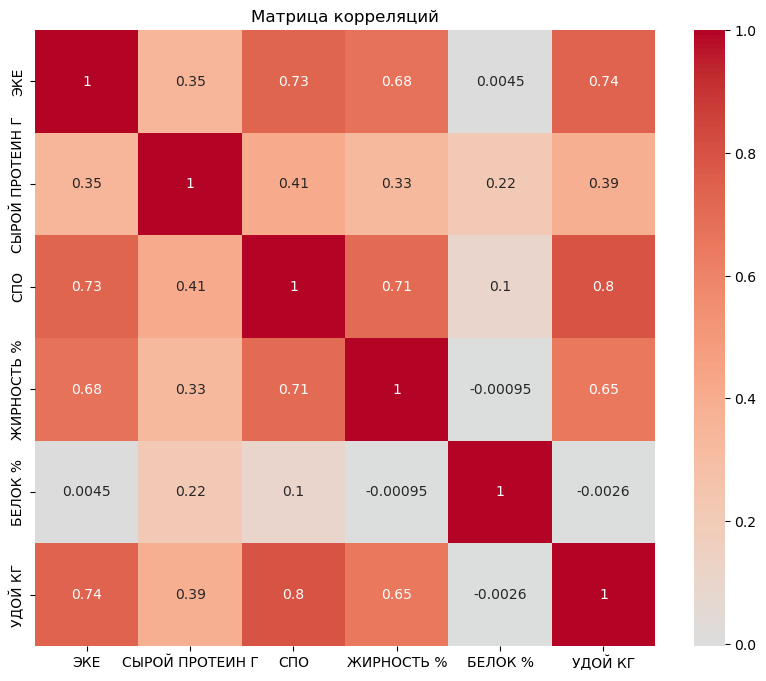

In [116]:
# Тепловая карта всех корреляций
all_features = numeric_features + category_features
corr_matrix = ferma_main_df[all_features + ['УДОЙ КГ']].select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций')
plt.show()

Здесь мы видим, что:
* на удой больше всего влияют СПО (сахарно-протеиновое соотношение) и ЭКЕ (энергетическая кормовая единица), 
* а также коровы, имеющие способность давать большой удой дают более жирное молоко, а также больше протеина содержится в этом молоке (но этот показатель в 2 раза менее зависим).
* соответсвенно качественное питание по признаку сахарно-протеинового соотношения повышает жирность молока.

Есть ли нелинейные связи между признаками?

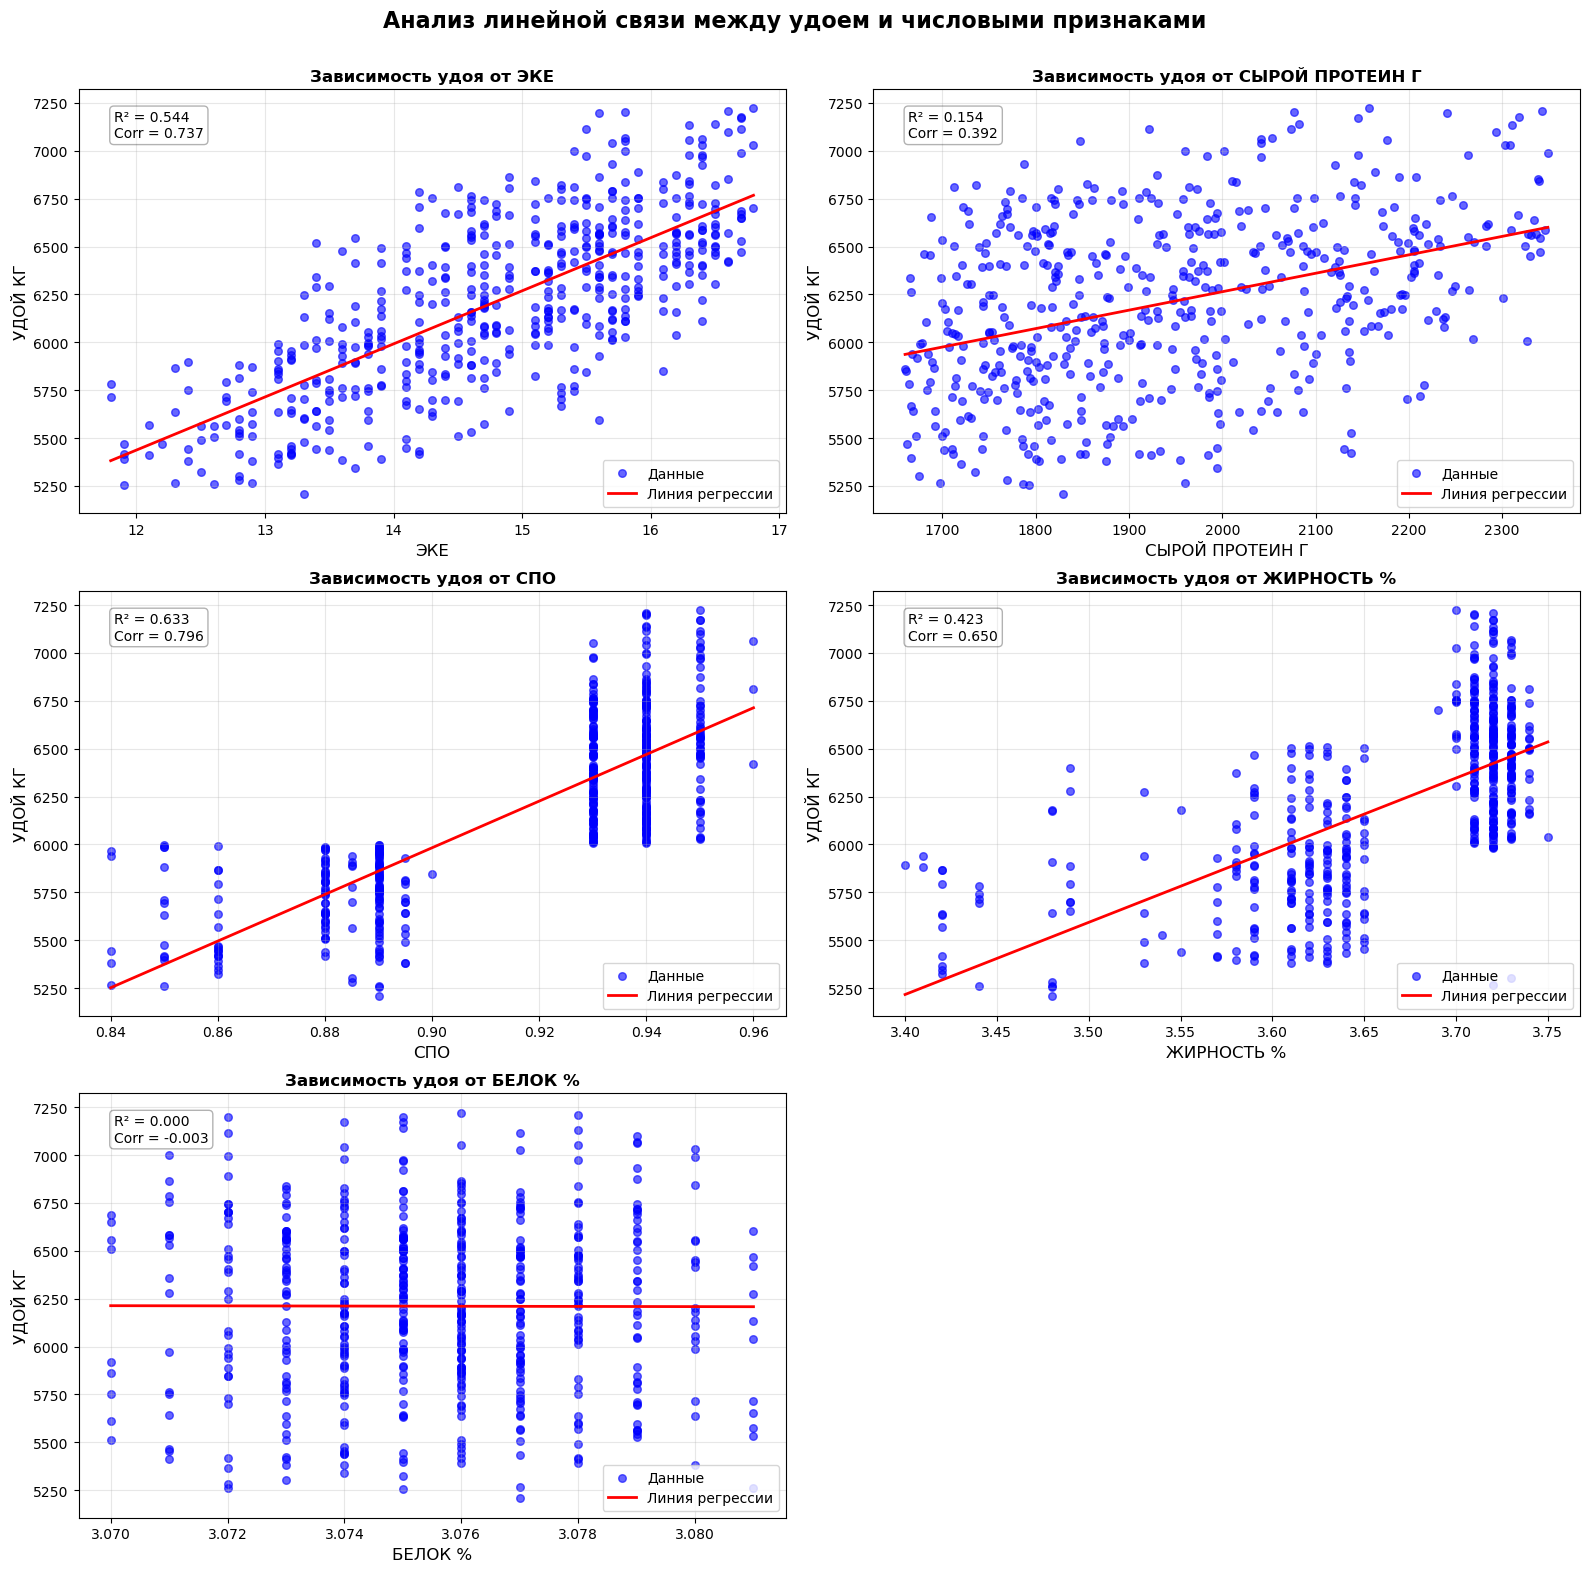

In [117]:
# Создаем сетку графиков
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    if ferma_main_df[feature].var() > 0:  # Проверяем, что есть вариация
        # Scatter plot
        axes[i].scatter(ferma_main_df[feature], ferma_main_df['УДОЙ КГ'], alpha=0.6, color='blue', 
                       label='Данные', s=30)
        
        # Линия регрессии
        X = ferma_main_df[feature].values.reshape(-1, 1)
        y = ferma_main_df['УДОЙ КГ'].values
        
        reg = LinearRegression().fit(X, y)
        x_line = np.linspace(ferma_main_df[feature].min(), ferma_main_df[feature].max(), 100)
        y_line = reg.predict(x_line.reshape(-1, 1))
        
        axes[i].plot(x_line, y_line, color='red', linewidth=2, 
                    label=f'Линия регрессии')
        
        # Добавляем статистики
        r2 = reg.score(X, y)
        corr = np.corrcoef(ferma_main_df[feature], ferma_main_df['УДОЙ КГ'])[0, 1]
        
        # Текстовые аннотации
        axes[i].text(0.05, 0.95, f'R² = {r2:.3f}\nCorr = {corr:.3f}', 
                    transform=axes[i].transAxes, 
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.3),
                    verticalalignment='top', fontsize=10)
        
        # Подписи осей и заголовок
        axes[i].set_xlabel(feature, fontsize=12)
        axes[i].set_ylabel('УДОЙ КГ', fontsize=12)
        axes[i].set_title(f'Зависимость удоя от {feature}', fontsize=12, fontweight='bold')
        
        # Легенда
        axes[i].legend(loc='lower right', fontsize=10)
        
        # Сетка
        axes[i].grid(True, alpha=0.3)
        
    else:
        axes[i].text(0.5, 0.5, f'{feature}\n(константа)', 
                    ha='center', va='center', transform=axes[i].transAxes,
                    fontsize=12, bbox=dict(boxstyle='round', facecolor='lightgray'))
        axes[i].set_title(f'{feature} - нет вариации', fontsize=14)

# Убираем лишние подграфики
for j in range(len(numeric_features), len(axes)):
    fig.delaxes(axes[j])

# Общий заголовок
fig.suptitle('Анализ линейной связи между удоем и числовыми признаками', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

<div style="background-color: #d4edda; color: #155724; padding: 15px; border-radius: 4px; border: 1px solid #c3e6cb;">

<b>Комментарий ревьюера v1:</b>

Твои выводы корректны и хорошо обоснованы на основе анализа scatterplot-диаграмм и коэффициентов корреляции. 👍

наиболее сильную линейную связь мы видим между:
* удоем и СПО
* удоем и ЭКЕ
* удоем и жирностью

Слабая связь наблюдается между:
* удоем и сырым протеином
* удоем и белком

Нужно ли вводить в модель дополнительные факторы, чтобы это учесть?

Мы думаем, что стоит вводить дополнительные факторы, чтобы учесть взаимосвязь между СПО, жирностью и удоем. Но в таблице, рассматриваемых к покупке из доступных количественных показателей, которые имеют наиболее выраженное значение только жирность. Поэтому в будущей модели нужно отдать жирности немаловажное значение.

На наш взгляд, мультиколлениарность не наблюдается.

# **Шаг 5. Обучение модели линейной регрессии**

Создадим функцию для обучения модели и вывода метрик.

In [ ]:
def train_model(number, df, features, numeric_features, category_features, target=None, trained_mobel=None):
    """Обучает модель, выводит метрики для оценки качества модели."""

    # Создаем датасет для модели
    X = df[features].copy()
    y = df[target].copy()

    # 2. Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 4. Создаем препроцессор
    preprocessor = ColumnTransformer(transformers=[
                                                    ('num', StandardScaler(), numeric_features),
                                                    ('cat', OneHotEncoder(drop='first'), category_features)
                                                    ])

    # 5. Создаем пайплайн с моделью
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

    # 6. Обучаем модель
    model.fit(X_train, y_train)

    # 7. Делаем прогнозы
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # 8. Оценка качества модели
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    residuals_test = y_test - y_pred_test
    residuals_train = y_train - y_pred_train

    mse_test = mean_squared_error(y_test, y_pred_test)  # mse_test = np.mean(residuals_test ** 2)
    mae_test = np.mean(np.abs(residuals_test))
    rmse_test = np.sqrt(mse_test)

    print(f"=== МЕТРИКИ {number} МОДЕЛИ ===")
    print(f"R² train: {r2_train:.4f}")
    print(f"R² test: {r2_test:.4f} - чем выше, тем лучше. test должен быть чуть выше train")
    if (r2_test - r2_train) > 0.15:
        print("r2_test > r2_train: Когда R² test сильно выше, чем R² train - это недообучение")
        print(" - Проверить на кросс-валидации - самое важное!")
        print(" - Увеличить сложность модели (больше параметров)")
        print(" - Добавить признаки или улучшить feature engineering")
        print(" - Проанализировать данные на предмет аномалий")

    if r2_test >= 0.80:
        print("r2_test >= 0.80: Когда R² test выше 0.80 - это хорошо. Превосходная модель готова к продакшену ")
    elif r2_test >= 0.70:
        print("r2_test >= 0.70: Когда R² test выше 0.70 - это примелемо, но можно поискать возможности для улучшения. ")
    else:
        print("r2_test < 0.70: Слабая модель требует улучшения. ")

        
    # ВЫБРОСЫ
    # outliers = "Есть" if rmse_test > mae_test else "Нет"

    print()
    print(f"RMSE test: {rmse_test:.2f} - чем меньше, тем лучше")
    print(f"MSE test:  {mse_test:.2f} - чем меньше, тем лучше")
    print(f"MAE test: {mae_test:.2f} - чем меньше, тем лучше")
    # print(f"Выбросы: {outliers}")

    print("\n=== АНАЛИЗ ОСТАТКОВ ===")
    print("ОСТАТКИ НА ОБУЧАЮЩЕЙ ВЫБОРКЕ (для сравнения):")
    print(f"Среднее значение: {residuals_train.mean():.2f}")
    print(f"Стандартное отклонение: {residuals_train.std():.2f}")
    print(f"Диапазон остатков: {residuals_train.min():.2f} до {residuals_train.max():.2f}")
    print(f"Размах: {residuals_train.max() - residuals_train.min():.2f}")

    range_train = residuals_train.max() - residuals_train.min()
    bias_percent = (residuals_train.mean() / range_train) * 100
    print(f"Смещение: {bias_percent:.2f}%")

    print("\nОСТАТКИ НА ТЕСТОВОЙ ВЫБОРКЕ (основные, смотреть сюда):")
    print(f"Среднее значение: {residuals_test.mean():.2f}")
    print(f"Стандартное отклонение: {residuals_test.std():.2f}")
    print(f"Дипазон остатков: {residuals_test.min():.2f} до {residuals_test.max():.2f}")
    print(f"Размах: {residuals_test.max() - residuals_test.min():.2f}")
    print(f"Смещение: {bias_percent:.2f}%\n")

    
    # подсчет доверительных интервалов через перцентили
    alpha = (1 - 0.95) / 2
    lower_percentile = alpha * 100
    upper_percentile = (1 - alpha) * 100
    
    lower_bound = np.percentile(residuals_test, lower_percentile).round(1)
    upper_bound = np.percentile(residuals_test, upper_percentile).round(1)

    CI = (lower_bound, upper_bound)

    print(f"95% доверительный интервал: [{CI[0]:.1f}, {CI[1]:.1f}] кг")
    print(f"Это означает: 95% ошибок лежат в диапазоне ±{max(abs(lower_bound), abs(upper_bound)):.0f} кг \n")

    range_test = residuals_test.max() - residuals_test.min()
    bias_percent = (residuals_test.mean() / range_test) * 100

    if bias_percent < 5:
        print("   - Смещение небольшое (хорошо: можно использовать)")
    elif bias_percent < 10:
        print("   - Смещение среднее (требует внимания: можно добавить поправочный коэффициент)")
    elif bias_percent < 20:
        print("   - Смещение большое (требует внимания: рекомендуется коррекция или улучшение модели)")
    elif bias_percent > 20:
        print("   - Смещение очень большое (критично: Обязательная доработка модели)")

    if residuals_test.std() < residuals_train.std():
        print(f"   - Стандартное отклонение на тесте меньше, чем на обучении: модель не переобучена")

    # Проверка нормальности остатков
    _, p_value = stats.shapiro(residuals_test)
    if p_value > 0.05:
        print("   - Остатки распределены нормально (хорошо)")
    else:
        print("   - Остатки НЕ распределены нормально (требует внимания)")

    # Проверка гомоскедастичности
    correlation_residuals = np.corrcoef(y_pred_test, np.abs(residuals_test))[0, 1]
    if abs(correlation_residuals) < 0.3:
        print("   - Гомоскедастичность соблюдена (хорошо) - постоянная дисперсия остатков")
    else:
        print("   - Возможна гетероскедастичность (требует внимания)")

    if r2_test > 0.7:
        print("   - Модель показывает хорошее качество предсказаний")
    elif r2_test > 0.6:
        print("   - Модель показывает удовлетворительное качество")
    else:
        print("   - Модель показывает низкое качество предсказаний, требует улучшения")


    if r2_test > r2_train:
        print("\n 🚨 Тест лучше обучения")
        print("   - Модель кажется лучше, чем есть на самом деле")
        print("   - Завышенные ожидания от производительности")
        print("   - На новых данных модель может работать хуже")


    else:
        gap = r2_train - r2_test
        if gap < 0.05:
            print("✅ Отличная генерализация: модель хорошо работает на новых данных!")
        elif gap < 0.15:
            print("⚠️ Умеренное переобучение")
        else:
            print("🚨 Сильное переобучение")

    # 11. Получаем коэффициенты модели
    feature_names = (numeric_features + 
                    list(model.named_steps['preprocessor']
                        .named_transformers_['cat']
                        .get_feature_names_out(category_features)))

    coefficients = model.named_steps['regressor'].coef_ # коэф-признаки
    intercept = model.named_steps['regressor'].intercept_ # целевой признак - базовый член

    print(f"\nСвободный член: {intercept:.4f} л. - базовый удой. ")
    print(f"\n=== КОЭФФИЦИЕНТЫ МОДЕЛИ === (показывают силу и направление влияния каждого признака на целевую переменную)")

    for name, coef in zip(feature_names, coefficients):
        print(f"{name}: {coef:.4f}")
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    fig.suptitle(f'Анализ модели № {number}', 
             fontsize=16, fontweight='bold')

    # График 1: Гистограмма остатков
    sns.histplot(residuals_train, bins=30, alpha=0.7, label='Train', kde=True, ax=axes[0, 0])
    sns.histplot(residuals_test, bins=30, alpha=0.7, label='Test', kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Распределение остатков')
    axes[0, 0].legend()

    # График 2: Предсказания vs Реальность
    axes[0, 1].scatter(y_test, y_pred_test, alpha=0.6)
    axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0, 1].set_xlabel('Реальные значения')
    axes[0, 1].set_ylabel('Предсказанные значения')
    axes[0, 1].set_title(f'Предсказания vs Реальность (R² = {r2_test:.3f})')

    # График 3: Q-Q plot остатков
    stats.probplot(residuals_test, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot остатков')

    # График 4: Остатки vs Предсказания
    axes[1, 1].scatter(y_pred_test, residuals_test, alpha=0.6)
    axes[1, 1].axhline(y=0, color='r', linestyle='--')
    axes[1, 1].set_xlabel('Предсказанные значения')
    axes[1, 1].set_ylabel('Остатки')
    axes[1, 1].set_title('Остатки vs Предсказания')

    plt.tight_layout()
    plt.show()

    return model, residuals_test.mean(), r2_test, mae_test, mse_test, rmse_test, CI


## **5.1. ==== ПЕРВАЯ МОДЕЛЬ ====**

Построим модель линейной регрессии на данных датасета farm_main_df.csv.
Использукм в качестве целевого признак Удой.
Из всего набора факторов выберем признаки, которые подходят для нашей модели: 
* СПО;
* Жирность;
* Возраст; 
* Порода;
* Порода папы быка;
* ЭКЕ,

именно они лучше всего говорят об удое. Если руководствоваться здравым смыслом, то возможно очевидно, что не все характеристики молока влияют на удой, но в то же время очевидно, что высокая жирность молока (как критерий питательности молока) говорит о хорошем питании коровы, что позволит сделать прогноз по показателю жирности, что она дает хорошее молоко.

=== МЕТРИКИ 1 МОДЕЛИ ===
R² train: 0.8088
R² test: 0.8130 - чем выше, тем лучше
r2_test >= 0.80: Когда R² test выше 0.80 - это хорошо. Превосходная модель готова к продакшену 

RMSE test: 199.21 - чем меньше, тем лучше
MSE test:  39685.86 - чем меньше, тем лучше
MAE test: 158.91 - чем меньше, тем лучше

=== АНАЛИЗ ОСТАТКОВ ===
ОСТАТКИ НА ОБУЧАЮЩЕЙ ВЫБОРКЕ (для сравнения):
Среднее значение: -0.00
Стандартное отклонение: 193.34
Диапазон остатков: -538.82 до 570.71
Размах: 1109.53
Смещение: -0.00%

ОСТАТКИ НА ТЕСТОВОЙ ВЫБОРКЕ (основные, смотреть сюда):
Среднее значение: -12.93
Стандартное отклонение: 199.75
Дипазон остатков: -658.22 до 526.38
Размах: 1184.61
Смещение: -0.00%

95% доверительный интервал: [-376.1, 378.0] кг
Это означает: 95% ошибок лежат в диапазоне ±378 кг 

   - Смещение небольшое (хорошо: можно использовать)
   - Остатки распределены нормально (хорошо)
   - Гомоскедастичность соблюдена (хорошо) - постоянная дисперсия остатков
   - Модель показывает хорошее качество предс

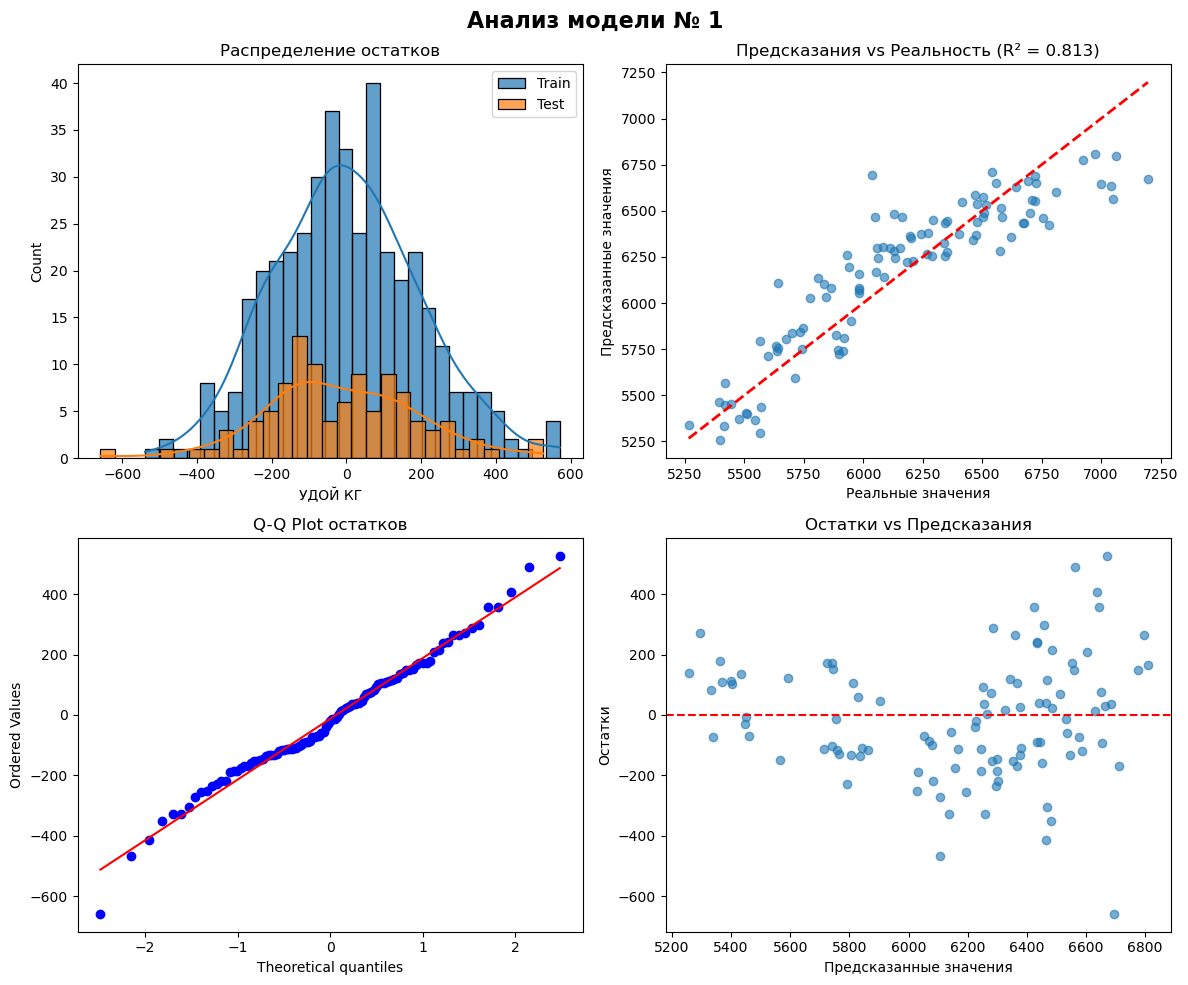

In [119]:
model_1, residuals_test_mean_1, r2_test_1, mae_test_1, mse_test_1, rmse_test_1, CI_1 = train_model(
    number=1,
    df=ferma_main_df, 
      features=['СПО', 'ЭКЕ', 'ЖИРНОСТЬ %', 'ВОЗРАСТ', 'ПОРОДА', 'ПОРОДА ПАПЫ БЫКА', 'СЫРОЙ ПРОТЕИН Г'], 
      numeric_features=['СПО', 'ЭКЕ', 'ЖИРНОСТЬ %', 'СЫРОЙ ПРОТЕИН Г'], 
      category_features=['ВОЗРАСТ', 'ПОРОДА', 'ПОРОДА ПАПЫ БЫКА'],
      target="УДОЙ КГ")

## **5.2. Дополнительные исследования**

### **5.2.1. Исключим нелинейность**

### **5.2.2. ==== ВТОРАЯ МОДЕЛЬ ====**

В здадании утерждается, что графики показывают, что СПО и Удой связаны нелинейно. (я, если честно, не совсем понимаю это утверждение из задания. если уж самая линейная связь из всех показывает нелинейность, то что тогда линейно - или я чего-то не понимаю) Исключим нелинейность: переведем СПО в категориальный признак, выявив и использовав границу нелинейности.

Рассмотрим три варианта категорирования числовых признаков:
1) методом pd.cut() - условно разделим значения колонки СПО на три бина ['низкий', 'средний', 'высокий']
2) через медиану СПО
3) перебором порогов перцентиля ([0.3, 0.5, 0.7, 0.8])

Наилучшие реультаты показал первый способ через бины ['низкий', 'средний', 'высокий'].

Поэтому будем использовать его 

In [120]:
# первый вариант категорирования признаков R2 0.75 (+7%), RMSE -30, MSE -15000, MAE - 90
spo_bins = pd.cut(ferma_main_df['СПО'], bins=3, retbins=True)[1]
ferma_main_df['СПО категория'] = pd.cut(ferma_main_df['СПО'], bins=spo_bins, labels=['низкий', 'средний', 'высокий'])
# 
# # второй вариант через медиану R2 0.68
# threshold_spo = ferma_main_df['СПО'].median()
# ferma_main_df['СПО категория'] = (ferma_main_df['СПО'] > threshold_spo).astype(int)

# # третий способ перцентили
# threshold_spo = ferma_main_df['СПО'].quantile(0.1)  # 30-й r2 = 0.72, 40-й r2 = 0.68, 60: r2 = 0.66
# ferma_main_df['СПО категория'] = (ferma_main_df['СПО'] > threshold_spo).astype(int)



ЭКЕ и Удой также связаны нелинейно. Исключим нелинейность: введем новый признак «ЭКЕ в квадрате».

In [121]:
# ЭКЕ -> квадратичный признак
ferma_main_df['ЭКЕ в квадрате'] = ferma_main_df['ЭКЕ'] ** 2

=== МЕТРИКИ 2 МОДЕЛИ ===
R² train: 0.7543
R² test: 0.7588 - чем выше, тем лучше
r2_test >= 0.70: Когда R² test выше 0.70 - это примелемо, но можно поискать возможности для улучшения. 

RMSE test: 226.21 - чем меньше, тем лучше
MSE test:  51169.23 - чем меньше, тем лучше
MAE test: 177.23 - чем меньше, тем лучше

=== АНАЛИЗ ОСТАТКОВ ===
ОСТАТКИ НА ОБУЧАЮЩЕЙ ВЫБОРКЕ (для сравнения):
Среднее значение: 0.00
Стандартное отклонение: 219.16
Диапазон остатков: -490.78 до 673.96
Размах: 1164.75
Смещение: 0.00%

ОСТАТКИ НА ТЕСТОВОЙ ВЫБОРКЕ (основные, смотреть сюда):
Среднее значение: -3.22
Стандартное отклонение: 227.27
Дипазон остатков: -558.39 до 656.60
Размах: 1214.98
Смещение: 0.00%

95% доверительный интервал: [-394.8, 502.5] кг
Это означает: 95% ошибок лежат в диапазоне ±502 кг 

   - Смещение небольшое (хорошо: можно использовать)
   - Остатки распределены нормально (хорошо)
   - Возможна гетероскедастичность (требует внимания)
   - Модель показывает хорошее качество предсказаний

 🚨 Тест 

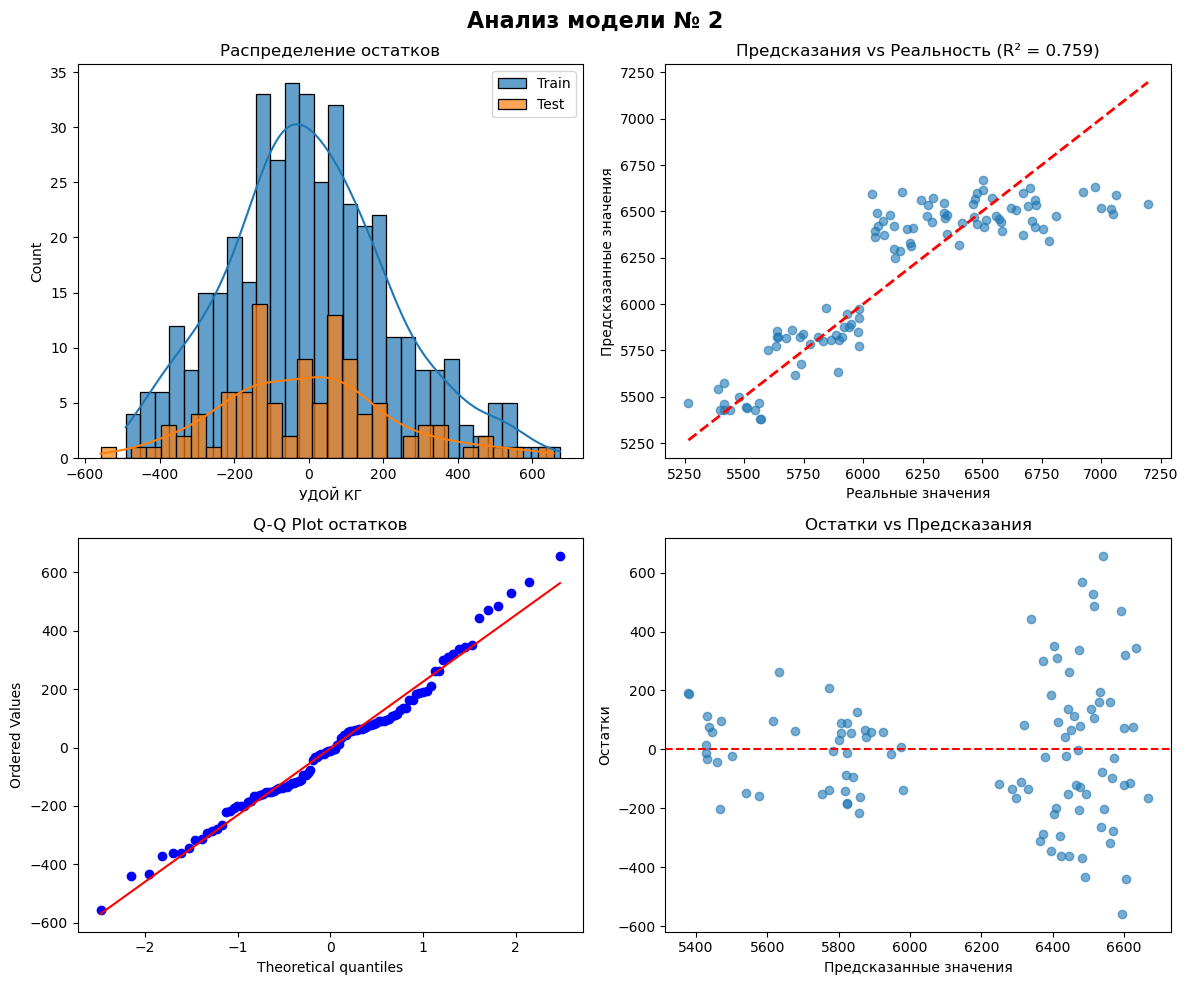

In [122]:
model_2, residuals_test_mean_2, r2_test_2, mae_test_2, mse_test_2, rmse_test_2, CI_2 = train_model(
    number=2,
    df=ferma_main_df, 
      features=['СПО категория', 'ЭКЕ в квадрате', 'ЖИРНОСТЬ %', 'ВОЗРАСТ', 'ПОРОДА', 'СЫРОЙ ПРОТЕИН Г'], 
      numeric_features=[ 'ЭКЕ в квадрате', 'ЖИРНОСТЬ %', 'СЫРОЙ ПРОТЕИН Г'], 
      category_features=['СПО категория', 'ВОЗРАСТ', 'ПОРОДА'],
      target="УДОЙ КГ")

## **5.3. Объединение датасетов в один**

### **5.3.1.==== ТРЕТЬЯ МОДЕЛЬ ====**

Построим модель линейной регрессии с учётом нового признака из файла ferma_dad.csv. 

Учтем преобразование нелинейности, а значит:
* В числовых оставим ['ЭКЕ в квадрате'] помимо стандартных числовых признаков ['ЖИРНОСТЬ %', 'СЫРОЙ ПРОТЕИН Г']
* Итого **числовые признаки:** ['ЭКЕ в квадрате', 'ЖИРНОСТЬ %', 'СЫРОЙ ПРОТЕИН Г']


* К стандартным категориальным признакам ['ВОЗРАСТ', 'ПОРОДА'] оставим новый признак ['СПО категория'] и добавим признаки из ferma_dad_df: ['ИМЯ ПАПЫ']
* итого **категориальные признаки** ['ВОЗРАСТ', 'ПОРОДА', 'СПО категория', 'ИМЯ ПАПЫ']

Объединим два датасета в один: ferma_main_df и ferma_dad_df. 

Очень смутило зачем объединять с датасетом ferma_dad_df: как может имя папы влиять на удой? Попробую с именем и без какой будет лучше тот и оставлю.

In [123]:
df = ferma_main_df.merge(ferma_dad_df, on='ID', how='left')
df = df[[ 'УДОЙ КГ', 'СПО категория', 'ЭКЕ в квадрате', 'ЖИРНОСТЬ %', 'ВОЗРАСТ', 'ПОРОДА', 'ИМЯ ПАПЫ', 'СЫРОЙ ПРОТЕИН Г']]
df.head(3)

,УДОЙ КГ,СПО категория,ЭКЕ в квадрате,ЖИРНОСТЬ %,ВОЗРАСТ,ПОРОДА,ИМЯ ПАПЫ,СЫРОЙ ПРОТЕИН Г
0,5863.00,средний,201.64,3.58,более_2_лет,Вис Бик Айдиал,Буйный,1743.00
1,5529.00,средний,163.84,3.54,менее_2_лет,Вис Бик Айдиал,Соловчик,2138.00
2,5895.00,средний,153.76,3.40,более_2_лет,РефлешнСоверинг,Буйный,2012.00


In [124]:
df.isnull().sum()

УДОЙ КГ            0
СПО категория      0
ЭКЕ в квадрате     0
ЖИРНОСТЬ %         0
ВОЗРАСТ            0
ПОРОДА             0
ИМЯ ПАПЫ           0
СЫРОЙ ПРОТЕИН Г    0
dtype: int64

In [125]:
df = check_null(df)

Нет пропусков в таблице


Обучим третью модель

=== МЕТРИКИ 3 МОДЕЛИ ===
R² train: 0.8460
R² test: 0.8450 - чем выше, тем лучше
r2_test >= 0.80: Когда R² test выше 0.80 - это хорошо. Превосходная модель готова к продакшену 

RMSE test: 181.35 - чем меньше, тем лучше
MSE test:  32888.61 - чем меньше, тем лучше
MAE test: 136.16 - чем меньше, тем лучше

=== АНАЛИЗ ОСТАТКОВ ===
ОСТАТКИ НА ОБУЧАЮЩЕЙ ВЫБОРКЕ (для сравнения):
Среднее значение: -0.00
Стандартное отклонение: 173.55
Диапазон остатков: -453.91 до 508.41
Размах: 962.32
Смещение: -0.00%

ОСТАТКИ НА ТЕСТОВОЙ ВЫБОРКЕ (основные, смотреть сюда):
Среднее значение: -9.91
Стандартное отклонение: 181.95
Дипазон остатков: -707.54 до 481.52
Размах: 1189.06
Смещение: -0.00%

95% доверительный интервал: [-323.8, 376.6] кг
Это означает: 95% ошибок лежат в диапазоне ±377 кг 

   - Смещение небольшое (хорошо: можно использовать)
   - Остатки НЕ распределены нормально (требует внимания)
   - Возможна гетероскедастичность (требует внимания)
   - Модель показывает хорошее качество предсказаний
✅ 

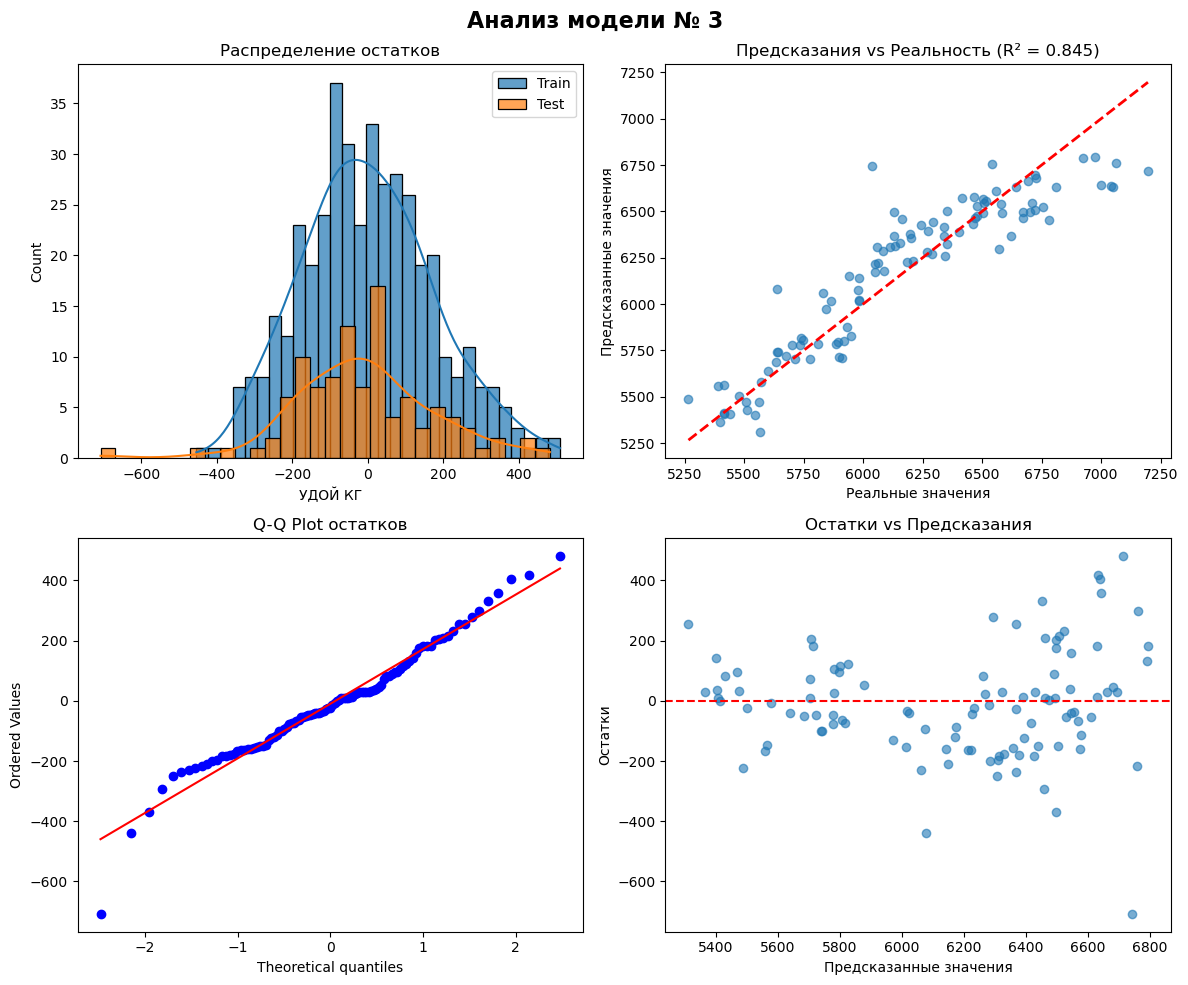

In [126]:
model_3, residuals_test_mean_3, r2_test_3, mae_test_3, mse_test_3, rmse_test_3, CI_3 = train_model(
    number=3,
    df=df, 
      features=['СПО категория', 'ЭКЕ в квадрате', 'ЖИРНОСТЬ %', 'ВОЗРАСТ', 'ПОРОДА', 'ИМЯ ПАПЫ', 'СЫРОЙ ПРОТЕИН Г'], 
      numeric_features=[ 'ЭКЕ в квадрате', 'ЖИРНОСТЬ %', 'СЫРОЙ ПРОТЕИН Г'], 
      category_features=['ВОЗРАСТ', 'ПОРОДА', 'СПО категория', 'ИМЯ ПАПЫ'],
      target="УДОЙ КГ")


### **5.4. Сравнение качества трех моделей**

Сравним качество трёх моделей линейной регрессии, сопоставим их R² и остатки.

In [127]:
data = [
    ["1", residuals_test_mean_1, r2_test_1, mse_test_1, mae_test_1, rmse_test_1, f'[{CI_1[0]:.1f} - {CI_1[1]:.1f}] кг' if CI_1 else CI_1],
    ["2", residuals_test_mean_2, r2_test_2, mse_test_2, mae_test_2, rmse_test_2, f'[{CI_2[0]:.1f} - {CI_2[1]:.1f}] кг' if CI_2 else CI_2],
    ["3", residuals_test_mean_3, r2_test_3, mse_test_3, mae_test_3, rmse_test_3, f'[{CI_3[0]:.1f} - {CI_3[1]:.1f}] кг' if CI_3 else CI_3]
]

# Создание датафрейма
compare_models_df = pd.DataFrame(data, columns=["Модель", "Среднее остатков", "R²", "MSE", "MAE", "RMSE", "Доверительный интервал"])

# Для расчета ширины интервала
compare_models_df['ДИ ширина'] = [ci[1] - ci[0] for ci in [CI_1, CI_2, CI_3]]

compare_models_df['Среднее остатков score'] = (compare_models_df['Среднее остатков'].abs() == compare_models_df['Среднее остатков'].abs().min()).astype(int)

compare_models_df['R² score'] = (compare_models_df['R²'] == compare_models_df['R²'].max()).astype(int)
compare_models_df['MSE score'] = (compare_models_df['MSE'] == compare_models_df['MSE'].min()).astype(int)
compare_models_df['MAE score'] = (compare_models_df['MAE'] == compare_models_df['MAE'].min()).astype(int)
compare_models_df['RMSE score'] = (compare_models_df['RMSE'] == compare_models_df['RMSE'].min()).astype(int)

# Оценка лучшего (наименьшая ширина)
compare_models_df['ДИ score'] = (compare_models_df['ДИ ширина'] == compare_models_df['ДИ ширина'].min()).astype(int)

compare_models_df['Скоринг ИТОГО'] = compare_models_df[['R² score', 'MSE score', 'MAE score', 'RMSE score', 'Среднее остатков score', 'ДИ score']].sum(axis=1)

compare_models_df["Вывод"] = (compare_models_df['Скоринг ИТОГО'] == compare_models_df['Скоринг ИТОГО'].max()).astype(int)
compare_models_df["Вывод"] = compare_models_df['Вывод'].map({1: "✅  Лучшая модель", 0: "Хуже"})

compare_models_df = compare_models_df[['Вывод', 'Модель', 'Среднее остатков', 'R²', 'MSE', 'MAE', 'RMSE', 'Доверительный интервал', 'ДИ ширина', 'Среднее остатков score', 'R² score', 'MSE score', 'MAE score', 'RMSE score', 'ДИ score', 'Скоринг ИТОГО']]

compare_models_df

,Вывод,Модель,Среднее остатков,R²,MSE,MAE,RMSE,Доверительный интервал,ДИ ширина,Среднее остатков score,R² score,MSE score,MAE score,RMSE score,ДИ score,Скоринг ИТОГО
0,Хуже,1,-12.93,0.81,39685.86,158.91,199.21,[-376.1 - 378.0] кг,754.10,0,0,0,0,0,0,0
1,Хуже,2,-3.22,0.76,51169.23,177.23,226.21,[-394.8 - 502.5] кг,897.30,1,0,0,0,0,0,1
2,✅ Лучшая модель,3,-9.91,0.84,32888.61,136.16,181.35,[-323.8 - 376.6] кг,700.40,0,1,1,1,1,1,5


Определили, что **третья модель лучшая**.

### **5.5.==== ИНФЕРЕНС УДОЯ ====**

Применим третью модель, лучшую по качеству и по точности, к данным из датасета cow_buy.csv и спрогнозируем удой коров, которых фермер хочет купить.

['СПО', 'СПО категория', 'ЭКЕ', 'ЭКЕ в квадрате', 'СЫРОЙ ПРОТЕИН Г'] - отсутсвуют в датафрейме cow_buy.csv. 

Возьмем их из основного датасета ferma_main_df и сразу при добавлении умножим на 5%. (Кроме СПО категория, так как это категориальный признак (слово не умножается). Рассчитаем его отдельно)

В техзадании нам поставлена задача в инференсе использовать средние значения из обучающих данных по недостающим признакам, которые мы увеличиваем на 5% (умножаем на 1.05). Так можно сделать, так как по легенде проекта фермер знает как он кормил своих коров (обучающие данные) и как собирается кормить коров, которых купит (данные о новых коровах).

In [128]:
cow_buy_df[['СПО', 'ЭКЕ', 'ЭКЕ в квадрате', 'СЫРОЙ ПРОТЕИН Г']] = ferma_main_df[['СПО','ЭКЕ', 'ЭКЕ в квадрате','СЫРОЙ ПРОТЕИН Г']] * 1.05

spo_bins = pd.cut(cow_buy_df['СПО'], bins=3, retbins=True)[1]
cow_buy_df['СПО категория'] = pd.cut(cow_buy_df['СПО'], bins=spo_bins, labels=['низкий', 'средний', 'высокий'])

In [129]:
cow_buy_df.head()

,ПОРОДА,ТИП ПАСТБИЩА,ПОРОДА ПАПЫ БЫКА,ИМЯ ПАПЫ,ЖИРНОСТЬ %,БЕЛОК %,ВОЗРАСТ,СПО,ЭКЕ,ЭКЕ в квадрате,СЫРОЙ ПРОТЕИН Г,СПО категория
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет,0.93,14.91,211.72,1830.15,низкий
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.08,менее_2_лет,0.93,13.44,172.03,2244.90,низкий
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.07,более_2_лет,0.93,13.02,161.45,2112.60,низкий
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.06,более_2_лет,0.93,13.44,172.03,1758.75,низкий
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.07,более_2_лет,NaN,NaN,NaN,NaN,NaN


Создадим функцию для получения прогноза, решил сделать отдельную функцию..

In [130]:
def inference_model(number, df, features, trained_model):
    """Делает предсказания с помощью обученной модели."""
    
    # Создаем датасет для предсказания
    X = df[features].copy()

    # Проверяем NaN перед предсказанием
    print(f"NaN в df до обработки: {X.isnull().sum().sum()}")
    
    # Обработка NaN если есть
    if X.isnull().sum().sum() > 0:
        print("Найдены NaN, заполняем...")
        for col in X.columns:
            if X[col].dtype in ['object', 'category']:
                X[col] = X[col].fillna(X[col].mode()[0] if not X[col].mode().empty else 'Unknown')
            else:
                X[col] = X[col].fillna(X[col].median())
    
    print(f"NaN в df после обработки: {X.isnull().sum().sum()}")

    # Делаем предсказания
    predictions = trained_model.predict(X)

    df['УДОЙ КГ (прогноз)'] = predictions
    
    print()
    print(f"=== ПРЕДСКАЗАНИЯ ДЛЯ {number} ===")
    print(f"Количество предсказаний: {len(predictions)}")
    print(f"Средний прогноз: {predictions.mean():.2f}")
    print(f"Диапазон: {predictions.min():.2f} - {predictions.max():.2f}")
    print(f"Стандартное отклонение: {predictions.std():.2f}")
    
    
    return df, predictions

Получим прогноз удоя коров.

In [131]:
df, predictions = inference_model(
    number='INFERENCE cow_buy',
    df=cow_buy_df, 
    features=['СПО', 'СПО категория', 'ЭКЕ в квадрате', 'ЭКЕ', 'ЖИРНОСТЬ %', 'ВОЗРАСТ', 'ПОРОДА', 'ПОРОДА ПАПЫ БЫКА', 'СЫРОЙ ПРОТЕИН Г', 'ИМЯ ПАПЫ'],
    trained_model=model_3  # обученная модель из model_3
)

NaN в df до обработки: 25
Найдены NaN, заполняем...
NaN в df после обработки: 0

=== ПРЕДСКАЗАНИЯ ДЛЯ INFERENCE cow_buy ===
Количество предсказаний: 16
Средний прогноз: 6190.40
Диапазон: 5704.66 - 6918.66
Стандартное отклонение: 304.40


In [132]:
df

,ПОРОДА,ТИП ПАСТБИЩА,ПОРОДА ПАПЫ БЫКА,ИМЯ ПАПЫ,ЖИРНОСТЬ %,БЕЛОК %,ВОЗРАСТ,СПО,ЭКЕ,ЭКЕ в квадрате,СЫРОЙ ПРОТЕИН Г,СПО категория,УДОЙ КГ (прогноз)
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет,0.93,14.91,211.72,1830.15,низкий,6120.81
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.08,менее_2_лет,0.93,13.44,172.03,2244.90,низкий,5818.14
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.07,более_2_лет,0.93,13.02,161.45,2112.60,низкий,5704.66
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.06,более_2_лет,0.93,13.44,172.03,1758.75,низкий,5812.01
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.07,более_2_лет,NaN,NaN,NaN,NaN,NaN,6434.76
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.05,менее_2_лет,0.93,13.86,182.95,1881.60,низкий,5877.13
6,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.08,более_2_лет,0.98,15.44,226.89,1896.30,высокий,6413.66
7,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.08,менее_2_лет,0.99,14.91,211.72,2013.90,высокий,6081.04
8,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.06,более_2_лет,NaN,NaN,NaN,NaN,NaN,6190.75
9,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.07,более_2_лет,NaN,NaN,NaN,NaN,NaN,6526.19


# **Шаг 6. Обучение модели логистической регрессии**

Построим модель логистической регрессии на данных датасета farm_main.csv.

**Целевой признак: "Вкус молока".**

In [133]:
numeric_features = ['ЭКЕ', 'ЭКЕ в квадрате', 'СПО', 'УДОЙ КГ', 'СЫРОЙ ПРОТЕИН Г', 'ЖИРНОСТЬ %', 'БЕЛОК %']
category_features = ['ПОРОДА', 'СПО категория', 'ТИП ПАСТБИЩА', 'ПОРОДА ПАПЫ БЫКА', 'ВОЗРАСТ']
target = 'ВКУС МОЛОКА'

Определить взаимосвязь между вкусом молока и другими признаками невозможно графиками и тепловой картой, потому что "Вкус молока" это категориальный признак.

Подсчитаем тогда сколько литров вкусного и невкусного молока.

In [134]:
print(ferma_main_df['ВКУС МОЛОКА'].value_counts())
print(f"\n Пропорции классов:")
print(ferma_main_df['ВКУС МОЛОКА'].value_counts(normalize=True))

ВКУС МОЛОКА
вкусно       314
не вкусно    208
Name: count, dtype: int64

 Пропорции классов:
ВКУС МОЛОКА
вкусно      0.60
не вкусно   0.40
Name: proportion, dtype: float64


Выбранные признаки:

In [135]:
features = [
    'БЕЛОК %',           # +1-2%
    'ЖИРНОСТЬ %',        # +1%
    'СЫРОЙ ПРОТЕИН Г',   # дает 19% Accuracy и Recall, - 20 Precision сам по себе белок бесвкусный, но думаю, все-таки влияет
    'СПО',               # дает + 5-12%.... Сахарно-протеиновое вещество влияет на концентрацию вкуса
    'СПО категория',     # +7% на линейной регрессии
    # 'ЭКЕ',               # никак
    'ЭКЕ в квадрате',      # + 5%
    'ПОРОДА',            # +2%
    # 'ВОЗРАСТ',           # хуже
    'УДОЙ КГ',            # удой дает +5 % на метриках
    # 'ТИП ПАСТБИЩА',     # снижает на 2%
    # 'ПОРОДА ПАПЫ БЫКА' # снижает на  1%
]

numeric_features = [
    'БЕЛОК %',
    'ЖИРНОСТЬ %', 
    'СЫРОЙ ПРОТЕИН Г', 
    'СПО', 
    # 'ЭКЕ',
    'ЭКЕ в квадрате',
    'УДОЙ КГ',
    ]
category_features = [
    # 'ТИП ПАСТБИЩА', 
    'СПО категория',
    # 'ПОРОДА ПАПЫ БЫКА',
    'ПОРОДА', 
    # 'ВОЗРАСТ'
    ]

Итого выбрали признаки, которые влияют на вкус молока: 
* Сырой протеин
* СПО
* ЭКЕ
* Удой
* Тип пастбища

Разделим данные на обучающую и тестовую выборки.

In [136]:
X = ferma_main_df[features].copy()
y = ferma_main_df['ВКУС МОЛОКА'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y
)

print(f"\nРазмер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")


Размер обучающей выборки: (417, 8)
Размер тестовой выборки: (105, 8)


Создадим препроцессор, который нормализует:
* категориальные признаки с помощью One-Hot Encoding 
* количественные признаки с помощью StandardScaler.

In [137]:
# Создание препроцессора
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), category_features)
    ]
)

In [138]:
# Создание пайплайна с логистической регрессией
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

Создадим модель логистической регрессии и получим прогноз.

In [139]:
# Обучение модели
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print("\n=== ОЦЕНКА КАЧЕСТВА МОДЕЛИ ===")


=== ОЦЕНКА КАЧЕСТВА МОДЕЛИ ===


Оценим качество модели на тестовой выборке: рассчитаем метрики accuracy, recall, precision.

In [140]:
# Основные метрики
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='вкусно') #  average='binary' - ищем только для вкусно
recall = recall_score(y_test, y_pred, pos_label='вкусно')


print(f"Чем больше, тем лучше")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Детальный отчет
print(f"\nДетальный отчет по классам:")
print(classification_report(y_test, y_pred))

Чем больше, тем лучше
Accuracy: 0.6667
Precision: 0.6892
Recall: 0.8095

Детальный отчет по классам:
              precision    recall  f1-score   support

      вкусно       0.69      0.81      0.74        63
   не вкусно       0.61      0.45      0.52        42

    accuracy                           0.67       105
   macro avg       0.65      0.63      0.63       105
weighted avg       0.66      0.67      0.65       105



**Общая оценка: ХОРОШАЯ модель** (67% общей точности Accuracy)

**Метрики для поиска вкусного молока:**

**Precision**: 69% - "Надежность покупок"

Из 100 коров, которых модель назвала "вкусными", 69 действительно дают вкусное молоко

31% ошибочных покупок - купите корову с невкусным молоком

**Recall**: 81% - "Охват хороших коров"

Из 100 коров с реально вкусным молоком модель найдет 81

19% упущенных возможностей - пропустите хороших коров

**Accuracy**: 67% - "Общая правильность решений"

67% всех решений о покупке правильные

**Проблемы модели**:

* Улучшилось распознавание "не вкусно" - Precision 61%, но Recall все еще низкий 45%

* Дисбаланс классов сохраняется - 63 "вкусно" vs 42 "не вкусно"

* Модель по-прежнему агрессивная - активно ищет вкусное молоко

**Бизнес-интерпретация:**

**Стратегия**: Модель стала более сбалансированной - находит больше хороших коров с меньшими ошибками

**Риск**: Каждая 3-я покупка может быть ошибочной (снизился с 36% до 31%)

**Выгода**: Найдете 81% всех хороших коров (рост с 73%)

**Рекомендация**: Модель значительно улучшилась и готова к практическому применению. Хороший баланс между поиском возможностей и минимизацией рисков.

**Но лучше пока не сделать**

Построим матрицу ошибок.

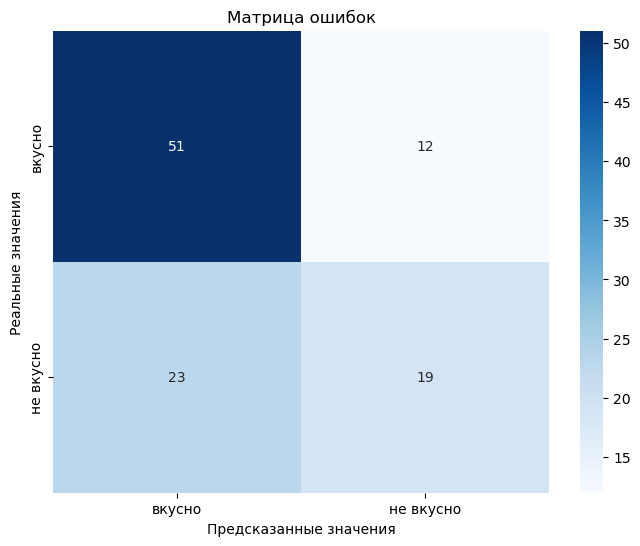

In [141]:
# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные значения')
plt.ylabel('Реальные значения')
plt.show()

In [142]:
print(f"\nМатрица ошибок:")
print(cm)


Матрица ошибок:
[[51 12]
 [23 19]]


**Проанализируем модель логистической регрессии.**

**Правильные предсказания:**

**TN** = 51 - правильно определили "вкусно" (True Negative)

**TP** = 19 - правильно определили "не вкусно" (True Positive)

**Всего правильных:** 70 из 105 (67% - Accuracy)

**Ошибки модели:**

**Ошибка I рода (False Positive)** = 23 (Сказали "вкусно", а молоко "не вкусно")

Бизнес-риск: Купили 23 коровы с невкусным молоком => Финансовые потери от неудачных покупок

**Ошибка II рода** (False Negative) = 12 (Сказали "не вкусно", а молоко "вкусно")

Упущенная выгода: Пропустили 12 коров с вкусным молоком => Потерянные возможности для прибыли

**Расчет метрик:**

**Precision** = 51/(51+23) = 69% - из купленных коров 69% с вкусным молоком

**Recall** = 51/(51+12) = 81% - из всех вкусных коров нашли 81%

**Accuracy** = (51+19)/105 = 67% - общая точность приемлемая

**Оценка модели:**

**СБАЛАНСИРОВАННАЯ и ЭФФЕКТИВНАЯ модель!**

* Находит 81% хороших коров (высокий Recall)

* 69% покупок успешные (приемлемый Precision)

* Разумный баланс между возможностями и рисками

**Рекомендация:**
Модель готова к практическому применению - хороший баланс метрик для коммерческого использования.




Объясним, какая ошибка критичнее всего при покупке коров: ложно-положительная или ложно-отрицательная. Сформулируем ответ с учётом метрик Recall и Precision.

При покупке коров критичнее **ЛОЖНО-ПОЛОЖИТЕЛЬНАЯ** ошибка:
- **Ложно-положительная:** купили корову, думая что молоко вкусное, а оно невкусное
- Ложно-отрицательная: не купили корову с вкусным молоком

**Ложно-положительная ошибка критичнее,** так как:
1. Финансовые потери от покупки плохой коровы больше
2. Испорченная репутация из-за плохого молока
3. Упущенная выгода от хорошей коровы меньше прямых потерь

Поэтому **важнее высокий PRECISION (точность) - минимизировать ложно-положительные ошибки**

Рассчитаем метрики для случая, когда критическая ошибка будет равна 0. Для этого нужно изменить вероятность принадлежности к положительному или отрицательному классу. Какой уровень этой вероятности?

In [143]:
# Предполагаем, что положительный класс - "вкусное" молоко
positive_class = 'вкусно' # Класс "не вкусно" игнорируется в расчете
positive_class_idx = list(model.classes_).index('вкусно') if 'вкусно' in model.classes_ else 1

thresholds = np.arange(0.1, 1.0, 0.01) # 0.346
best_threshold = 0.5
best_precision = 0

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba[:, positive_class_idx] >= threshold)
    y_pred_thresh_labels = np.where(y_pred_thresh, positive_class, 'не вкусно') # np.where(условие, значение_если_True, значение_если_False)
    
    try:
        precision_thresh = precision_score(y_test, y_pred_thresh_labels, pos_label=positive_class, zero_division=0)  # порог 0.79 / prec 1.0
        if precision_thresh > best_precision:   # в precision_score параметр average='binary' по умолчанию - для задач с четким целевым классом 'вкусно'
            best_precision = precision_thresh   # average='binary' Считает метрику только для ОДНОГО целевого класса", несмотря на свое название
            best_threshold = threshold
    except:
        continue

print(f"Определен оптимальный порог для максимизации precision: {best_threshold:.2f} \n- Высокий порог → высокий Precision, но низкий Recall (Покупаем редко, но метко)\n")
print(f'Рассчитан Precision {best_precision:.4f} при оптимальном пороге {best_threshold:.2f} \n- Считает Precision только для класса "вкусно"\n')

if best_precision.round(0) == 1:
    print(f'Precision 1.0 означает, что это 100% точность среди тех коров, чье молоко модель предсказала как "вкусно"')


# Предсказания с оптимальным порогом
y_pred_optimal = (y_pred_proba[:, positive_class_idx] >= best_threshold)
y_pred_optimal_labels = np.where(y_pred_optimal, 'вкусно', 'не вкусно')  # np.where(условие: если вероятность вкусно порога >= порога, значение_если_True, значение_если_False)
      
# Рассчитываем все метрики с одинаковыми параметрами
precision_optimal = precision_score(y_test, y_pred_optimal_labels, pos_label='вкусно', zero_division=0) # binary по умолчанию
recall_optimal = recall_score(y_test, y_pred_optimal_labels, pos_label='вкусно', zero_division=0)
accuracy_optimal = accuracy_score(y_test, y_pred_optimal_labels)

print()
print(f'Метрики с оптимальным порогом {best_threshold.round(2)} только для "вкусно":')
print(f'- Precision: {precision_optimal:.4f} - это 100% точность среди тех коров, чье молоко модель предсказала как "вкусно"')
print(f"- Recall: {recall_optimal:.4f} - доля коров со вкусным молоком. (Если низкий Recall = много упущенных возможностей)")
print(f"- Accuracy: {accuracy_optimal:.4f} - доля правильных решений при покупке коровы с вкусным молоком")    

print()
if best_precision.round(0) == 1:
    print(f'Если Precision 1.0: это означает, что модель никогда не ошибается при покупке коровы с вкусным молоком')
    print(f'- Когда модель говорит "вкусно" - она никогда не ошибается')
    print(f'- Но она очень консервативна - предсказывает "вкусно" редко')
    print(f'- Много коров с вкусным молоком она пропускает (низкий Recall)\n')
    print(f'- Крайне высокий порог {best_threshold.round(2)} - модель сверхконсервативна: модель покупает только при {int(best_threshold.round(2)*100)}% уверенности')

Определен оптимальный порог для максимизации precision: 0.91 
- Высокий порог → высокий Precision, но низкий Recall (Покупаем редко, но метко)

Рассчитан Precision 1.0000 при оптимальном пороге 0.91 
- Считает Precision только для класса "вкусно"

Precision 1.0 означает, что это 100% точность среди тех коров, чье молоко модель предсказала как "вкусно"

Метрики с оптимальным порогом 0.91 только для "вкусно":
- Precision: 1.0000 - это 100% точность среди тех коров, чье молоко модель предсказала как "вкусно"
- Recall: 0.0159 - доля коров со вкусным молоком. (Если низкий Recall = много упущенных возможностей)
- Accuracy: 0.4095 - доля правильных решений при покупке коровы с вкусным молоком

Если Precision 1.0: это означает, что модель никогда не ошибается при покупке коровы с вкусным молоком
- Когда модель говорит "вкусно" - она никогда не ошибается
- Но она очень консервативна - предсказывает "вкусно" редко
- Много коров с вкусным молоком она пропускает (низкий Recall)

- Крайне высокий п

Использовать этот вариант модели логистической регрессии.

Для сравнения добавляем недостающие признаки со средними значениями из обучающих данных (результат будет хуже - неиспользовать).

In [144]:
# Добавляем недостающие признаки со средними значениями из обучающих данных
cow_buy_df['СЫРОЙ ПРОТЕИН Г'] = ferma_main_df['СЫРОЙ ПРОТЕИН Г'].mean()
cow_buy_df['ЭКЕ'] = ferma_main_df['ЭКЕ'].mean()
cow_buy_df['СПО'] = ferma_main_df['СПО'].mean()
cow_buy_df['УДОЙ КГ'] = ferma_main_df['УДОЙ КГ'].mean()

# Обработка новых данных
X_new = cow_buy_df[features].copy()

# Обработка пропущенных значений
for col in X_new.columns:
    if X_new[col].dtype in ['object', 'category']:
        X_new[col] = X_new[col].fillna(X_new[col].mode()[0] if not X_new[col].mode().empty else 'Unknown')
    else:
        X_new[col] = X_new[col].fillna(X_new[col].median())

# Предсказания для новых коров
predictions = model.predict(X_new)
predictions_proba = model.predict_proba(X_new)

# Добавление результатов в датафрейм
cow_buy_df['Вкус молока (прогноз)'] = predictions
cow_buy_df['Вероятность вкусного молока'] = predictions_proba[:, positive_class_idx]

# Классификация с оптимальным порогом
optimal_predictions = (predictions_proba[:, positive_class_idx] >= best_threshold)
cow_buy_df['Вкус молока (оптимальный порог)'] = np.where(optimal_predictions, positive_class, 'не вкусно')

print(f"Результаты классификации новых коров:")
print(f"Всего коров для покупки: {len(cow_buy_df)}")
print(f"Прогноз с обычным порогом:")
print(cow_buy_df['Вкус молока (прогноз)'].value_counts())
print(f"\nПрогноз с оптимальным порогом ({best_threshold:.2f}):")
print(cow_buy_df['Вкус молока (оптимальный порог)'].value_counts())

# Показать топ-10 коров с наибольшей вероятностью вкусного молока
print(f"\nТоп-10 коров с наибольшей вероятностью вкусного молока:")
top_cows = cow_buy_df.nlargest(10, 'Вероятность вкусного молока')[
    ['ПОРОДА', 'ВОЗРАСТ', 'ЖИРНОСТЬ %', 'Вероятность вкусного молока', 'Вкус молока (оптимальный порог)']
]
print(top_cows)

print(f"\n=== ИТОГОВЫЙ АНАЛИЗ МОДЕЛИ ===")
print(f"Модель обучена на {len(ferma_main_df)} коровах")
print(f"Точность модели: {accuracy_optimal:.1%}")
print(f"Оптимальный порог для покупки коров: {best_threshold:.2f}")
print(f"Рекомендуется покупать коров с вероятностью вкусного молока > {best_threshold:.2f}")

Результаты классификации новых коров:
Всего коров для покупки: 16
Прогноз с обычным порогом:
Вкус молока (прогноз)
не вкусно    12
вкусно        4
Name: count, dtype: int64

Прогноз с оптимальным порогом (0.91):
Вкус молока (оптимальный порог)
не вкусно    16
Name: count, dtype: int64

Топ-10 коров с наибольшей вероятностью вкусного молока:
             ПОРОДА      ВОЗРАСТ  ЖИРНОСТЬ %  Вероятность вкусного молока Вкус молока (оптимальный порог)
13   Вис Бик Айдиал  более_2_лет        3.73                         0.77                       не вкусно
0    Вис Бик Айдиал  более_2_лет        3.58                         0.62                       не вкусно
6    Вис Бик Айдиал  более_2_лет        3.57                         0.58                       не вкусно
11   Вис Бик Айдиал  менее_2_лет        3.42                         0.57                       не вкусно
1    Вис Бик Айдиал  менее_2_лет        3.54                         0.47                       не вкусно
9   РефлешнСоверинг  

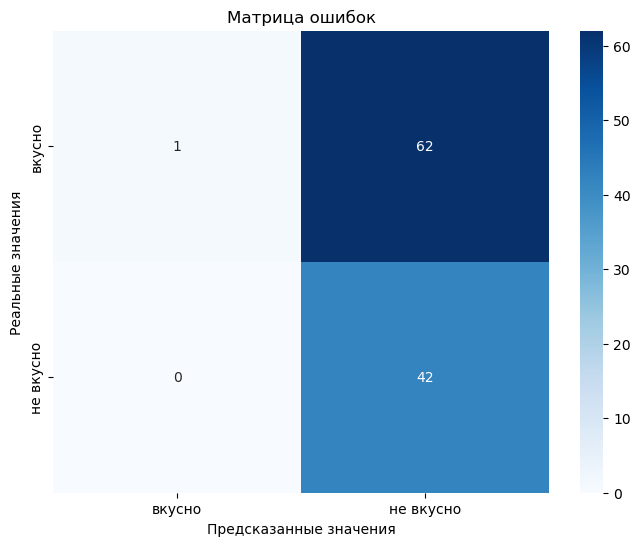

In [145]:
# Матрица ошибок
cm = confusion_matrix(y_test, y_pred_optimal_labels) # y_pred_optimal_labels - предсказания с оптимальным порогом
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные значения')
plt.ylabel('Реальные значения')
plt.show()

In [146]:
print(f"\nМатрица ошибок:\n {cm}")


Матрица ошибок:
 [[ 1 62]
 [ 0 42]]


**Расшифровка элементов:**

**Правильные предсказания:**

* **TP** = 1 - правильно определили "вкусно" (всего 1 случай!)

* **TN** = 42 - правильно определили "не вкусно"

**Всего правильных:** 43 из 105 (41%)

**Ошибки модели:**

* **FP** Ошибка I рода (False Positive) = 0: 

ИДЕАЛЬНО! Нет ложных покупок невкусного молока (Когда модель говорит "вкусно" - она не ошибается)

* **FN** Ошибка II рода (False Negative) = 62:

КРИТИЧЕСКАЯ ПРОБЛЕМА! Пропустили 62 коровы с вкусным молоком (Упущенная выгода: Не купили 62 хорошие коровы из 63!)

**Расчет метрик:**

* **Precision** = 1/(1+0) = 100% - из предсказанных "вкусно" все правильные

* **Recall** = 1/(1+62) = 1.6% - из реально вкусных нашли только 1.6%

* **Accuracy** = (1+42)/105 = 41% - общая точность крайне низкая

**Оценка модели и cтратегические варианты:**

<u>1. Если бюджет ограничен и критичны финансовые потери:</u>

* ОСТАВИТЬ текущую модель - она гарантирует успешные покупки

* Каждая покупка будет прибыльной (100% Precision)

* Подходит для консервативной стратегии

<u>2. Если нужен рост бизнеса и масштабирование:</u>

* СНИЗИТЬ порог классификации для увеличения Recall

* Цель: найти баланс между Precision и Recall (например, 70% Precision, 30% Recall)

* Готовность к некоторым ошибочным покупкам ради роста объемов

<u>3. Гибридная стратегия:</u>

* Использовать два порога: высокий (текущий) для гарантированных покупок

* Низкий порог для дополнительных возможностей с повышенным риском

**Итоговая рекомендация:**

* Модель технически работает правильно. Выбор зависит от бизнес-стратегии:

* Консервативный подход → оставить как есть

* Агрессивный рост → снизить порог до 0.3-0.5

# **Шаг 7. Итоговые выводы**

Выведем прогнозы вкуса молока и удоя коров «ЭкоФермы» в одной таблице DataFrame.

Отберем коров, для которых спрогнозирован удой более 6000 килограммов в год и вкусное молоко.

In [147]:
cow_buy_df[cow_buy_df['УДОЙ КГ (прогноз)'] > 6000]

,ПОРОДА,ТИП ПАСТБИЩА,ПОРОДА ПАПЫ БЫКА,ИМЯ ПАПЫ,ЖИРНОСТЬ %,БЕЛОК %,ВОЗРАСТ,СПО,ЭКЕ,ЭКЕ в квадрате,СЫРОЙ ПРОТЕИН Г,СПО категория,УДОЙ КГ (прогноз),УДОЙ КГ,Вкус молока (прогноз),Вероятность вкусного молока,Вкус молока (оптимальный порог)
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет,0.92,14.79,211.72,1944.52,низкий,6120.81,6210.77,вкусно,0.62,не вкусно
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.07,более_2_лет,0.92,14.79,NaN,1944.52,NaN,6434.76,6210.77,не вкусно,0.43,не вкусно
6,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.08,более_2_лет,0.92,14.79,226.89,1944.52,высокий,6413.66,6210.77,вкусно,0.58,не вкусно
7,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.08,менее_2_лет,0.92,14.79,211.72,1944.52,высокий,6081.04,6210.77,не вкусно,0.40,не вкусно
8,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.06,более_2_лет,0.92,14.79,NaN,1944.52,NaN,6190.75,6210.77,не вкусно,0.21,не вкусно
9,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.07,более_2_лет,0.92,14.79,NaN,1944.52,NaN,6526.19,6210.77,не вкусно,0.45,не вкусно
10,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.68,3.05,более_2_лет,0.92,14.79,285.86,1944.52,высокий,6918.66,6210.77,не вкусно,0.41,не вкусно
12,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.06,более_2_лет,0.92,14.79,220.76,1944.52,высокий,6280.83,6210.77,не вкусно,0.24,не вкусно
13,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.08,более_2_лет,0.92,14.79,255.53,1944.52,высокий,6349.08,6210.77,вкусно,0.77,не вкусно
14,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.77,3.05,менее_2_лет,0.92,14.79,NaN,1944.52,NaN,6345.59,6210.77,не вкусно,0.19,не вкусно


Коротко опишем результаты работы модели для фермера.

**Сколько коров он может купить из стада на продажу с минимальным риском для себя? Почему?**
* С минимальным риском для себя он может купить 15 коров, именно столько окров дают удой выше среднего 6000 кг.

**Какие ещё рекомендации можно ему дать?**

При ведении бизнеса и покупке новых коров следует учитывать, что:
* Больше всего на удой влияет СПО (Сахарно-Протеиновое соотношение) и ЭКЕ (Энергетиеская кормовая единица), то еть нужно больше внимание уделить питанию коров. 
* Коровы породы Айдиал дают немного больше удоя, чем Северины. 
* Коровы старше двух лет дают больше молока.

**Какие способы улучшения качества регрессионной модели использовали в этой задаче?**

Третья модль по метрикам оказалась наиболее эффективной. Мы использовали предложенные способы для улучшения: 
* перевести числовой признак СПО в категориальный;
* возвести ЭКЕ в квадрат.
* перебирал признаки и определял степень их влияния на метрики.

* **Возможно ли ещё улучшить результаты регрессионной модели? Если можно, то как?**

1. **Инженерия признаков:** 
* между числовыми признаками пробовать производить математические действия (умножать возводить в квадрат);
* Добавить полиномиальные признаки 
* from sklearn.preprocessing import PolynomialFeatures poly = PolynomialFeatures(degree=2, include_bias=False);
2. **Регуляризация:**
* from sklearn.linear_model import Ridge, Lasso, ElasticNet
3. **Другие алгоритмы:** 
* from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
* from sklearn.svm import SVR
4. **Подбор гиперпараметров:**
* from sklearn.model_selection import GridSearchCV

**Какие метрики моделей классификации, в том числе логистической регрессии, важны при анализе рисков или экономических расчётов?**
1. **Precision** (Точность) - критична при высокой стоимости ложно-положительных ошибок. Precision приоритетна в покупке коров (избежать плохого качества молока)
2. **Recall** (Полнота) - важна при высокой стоимости пропуска возможностей. Recall приоритетен в маркетинге и медицине (охватить больше клиентов, не пропустить болезнь)
3. **Экономические метрики:**
* **Ожидаемая прибыль** = (TP * profit_per_tp) + (TN * profit_per_tn) - (FP * cost_per_fp) - (FN * cost_per_fn) (приоритетен в инвестициях)
* **roi** = (profit_with_model - profit_without_model) / cost_of_model
* **cost_matrix** = [[0, cost_fn], [cost_fp, 0]]
4. **Пороговые метрики**.